# w261 Final Project - Clickthrough Rate Prediction


# Team & Members

Team #21

Brent Biseda  
Katie Mo  
Teddy Fong  
Thanh Le  
Summer 2019, section 4   

In [1]:
# imports
import re
import ast
import time
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.types import *
import sys
from pyspark.sql import SQLContext
from pyspark.ml.feature import VectorAssembler
import pyspark.sql.functions as F
from pyspark.mllib.util import MLUtils
from pyspark.ml.feature import StandardScaler
from pyspark.sql import SparkSession
from pyspark.ml.feature import OneHotEncoderEstimator, OneHotEncoderModel
from pyspark.ml.feature import OneHotEncoder, StringIndexer, StandardScaler, Imputer, VectorAssembler, SQLTransformer
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel
from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics

pd.set_option('display.max_columns', 40)
%matplotlib inline  

import warnings
warnings.simplefilter("ignore", UserWarning)

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
# store path to notebook
PWD = !pwd
PWD = PWD[0]

In [4]:
# start Spark Session
from pyspark.sql import SparkSession
app_name = "final_project_notebook"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()

In [5]:
sc = spark.sparkContext
sqlContext = SQLContext(sc)

In [6]:
spark

In [7]:
sc._conf.getAll()

[('spark.app.name', 'final_project_notebook'),
 ('spark.driver.port', '35559'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.app.id', 'local-1575255207846'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.driver.host', 'docker.w261')]

In [31]:
# testRDD = sqlContext.read.parquet('test.parquet').rdd # This Loads an RDD
testDF = sqlContext.read.parquet('test.parquet') # This loads a Data Frame

In [32]:
# trainRDD = sqlContext.read.parquet('train.parquet').rdd
trainDF = sqlContext.read.parquet('train.parquet')

In [33]:
HEADER = trainDF.columns
INTEGER_FEATURES = HEADER[0:14] # These are the integer features
CATEGORICAL_FEATURES = HEADER[14:] # These are the categorical features

# Create Sample Datasets

In [11]:
sample = trainDF.sample(False, 0.0001, seed=1234).toPandas() # Approximately 5000 records

In [59]:
sample.head()

,y,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39
0,0.0,NaN,9.0,5.0,5.0,1543.0,NaN,0.0,5.0,64.0,...,1e88c74f,df4fffb7,21ddcdc9,5840adea,b9fac036,,32c7478e,625964a3,010f6491,aa5f0a15
1,0.0,NaN,45.0,4.0,4.0,610.0,31.0,2.0,27.0,31.0,...,07c540c4,d4328054,,,0014c32a,,bcdee96c,3b183c5c,,
2,0.0,NaN,105.0,15.0,12.0,103.0,NaN,0.0,29.0,26.0,...,07c540c4,e96a7df2,,,5fe17899,,423fab69,cafb4e4d,,
3,0.0,NaN,54.0,94.0,2.0,190275.0,NaN,0.0,2.0,1.0,...,e5ba7672,5aed7436,21ddcdc9,b1252a9d,c2c9ac18,,32c7478e,9bafd547,e8b83407,1bae8608
4,0.0,NaN,8.0,8.0,1.0,212127.0,NaN,0.0,3.0,1.0,...,d4bb7bd8,7ef5affa,21ddcdc9,b1252a9d,04507927,,32c7478e,3fdb382b,e8b83407,49d68486


In [24]:
sample.describe()

,y,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13
count,4490.000000,2479.000000,4490.000000,3534.000000,3519.000000,4.382000e+03,3509.000000,4304.000000,4489.000000,4304.000000,2479.000000,4304.000000,1076.000000,3519.000000
mean,0.250334,3.478419,100.195768,19.849745,7.391589,1.896299e+04,117.514107,17.000929,12.658944,105.194470,0.628883,2.738151,1.047398,8.136402
std,0.433254,8.166513,365.471204,65.337278,8.991854,7.087508e+04,305.514296,69.786757,16.039521,216.325935,0.717186,5.277780,5.229130,12.978932
min,0.000000,0.000000,-2.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,2.000000,2.000000,3.130000e+02,8.000000,1.000000,2.000000,11.000000,0.000000,1.000000,0.000000,2.000000
50%,0.000000,1.000000,3.000000,6.000000,4.000000,2.748500e+03,32.000000,3.000000,7.000000,39.000000,1.000000,1.000000,0.000000,4.000000
75%,1.000000,3.000000,35.000000,18.000000,10.000000,1.000475e+04,106.000000,12.000000,19.000000,109.250000,1.000000,3.000000,1.000000,10.000000
max,1.000000,176.000000,7380.000000,1949.000000,132.000000,1.225942e+06,9568.000000,2438.000000,618.000000,6358.000000,7.000000,90.000000,87.000000,430.000000


In [17]:
sample.describe(include="object")

,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39
count,4490,4490,4490,4490,4490,4490,4490,4490,4490,4490,4490,4490,4490,4490,4490,4490,4490,4490,4490,4490,4490,4490,4490,4490,4490,4490
unique,128,336,2953,2249,37,9,2066,69,3,1912,1478,2813,1262,22,1421,2572,9,866,346,4,2703,8,13,1541,39,1129
top,05db9164,38a947a1,,,25c83c98,7e0ccccf,1c86e0eb,0b153874,a73ee510,3b08e48b,755e4a50,,5978055e,b28479f6,2d0bb053,,e5ba7672,e88ffc9d,,,,,32c7478e,3fdb382b,,
freq,2306,523,146,146,3039,1767,90,2684,4042,981,142,146,142,1559,52,146,2083,141,1962,1962,146,3427,1995,235,1962,1962


In [14]:
testdata = trainDF.sample(False, 0.0001, seed=1234)

In [17]:
testdata.take(1)

[Row(y=0.0, x1=None, x2=9.0, x3=5.0, x4=5.0, x5=1543.0, x6=None, x7=0.0, x8=5.0, x9=64.0, x10=None, x11=0.0, x12=None, x13=5.0, x14='05db9164', x15='39dfaa0d', x16='2d226b41', x17='7f4c1fca', x18='25c83c98', x19='7e0ccccf', x20='b7dc9c31', x21='5b392875', x22='a73ee510', x23='bbaa2887', x24='19aaafd4', x25='04342c9f', x26='9a62ee76', x27='07d13a8f', x28='60fa10e5', x29='75293642', x30='1e88c74f', x31='df4fffb7', x32='21ddcdc9', x33='5840adea', x34='b9fac036', x35='', x36='32c7478e', x37='625964a3', x38='010f6491', x39='aa5f0a15')]

In [29]:
testdata.groupBy('x19').agg({"*": "count"}).collect()

[Row(x19='fbad5c96', count(1)=1023),
 Row(x19='3bf701e7', count(1)=77),
 Row(x19='fdf16bc4', count(1)=1),
 Row(x19='f1f2de2d', count(1)=1),
 Row(x19='6f6d9be8', count(1)=143),
 Row(x19='13718bbd', count(1)=125),
 Row(x19='fe6b92e5', count(1)=798),
 Row(x19='', count(1)=555),
 Row(x19='7e0ccccf', count(1)=1767)]

# Create Toy Example

In [14]:
toy_example = sample[5:15]
toy_example.reset_index(inplace=True,drop=True)

In [15]:
small_toy_example = toy_example[["y","x1","x2","x6","x8","x14","x19","x20","x35"]]

In [16]:
#small_toy_example.to_csv("toy_example.txt",index=None)
small_toy_example

,y,x1,x2,x6,x8,x14,x19,x20,x35
0,1.0,2.0,671.0,145.0,12.0,05db9164,fbad5c96,6c5e14ec,
1,0.0,0.0,-1.0,9.0,0.0,05db9164,6f6d9be8,2f5788d6,
2,0.0,NaN,0.0,100.0,0.0,8cf07265,7e0ccccf,2cc59e2b,ad3062eb
3,0.0,NaN,-1.0,NaN,0.0,05db9164,fbad5c96,d356c7e6,
4,0.0,NaN,1.0,203.0,5.0,68fd1e64,fbad5c96,d5f62b87,
5,0.0,1.0,-1.0,0.0,0.0,05db9164,,1b76cf1e,
6,1.0,NaN,39.0,NaN,117.0,5bfa8ab5,7e0ccccf,af0809a5,
7,0.0,NaN,0.0,66.0,7.0,05db9164,,da33ebe6,
8,1.0,10.0,1.0,66.0,27.0,05db9164,fbad5c96,ce4f7f55,
9,0.0,NaN,1.0,16.0,7.0,68fd1e64,7e0ccccf,5e64ce5f,


# EDA

In [11]:
#find number of examples in each class and in total
train_count = trainDF.count()

trainDF_0 = trainDF.where(F.col("y") == 0)
train_count_0 = trainDF_0.count()

trainDF_1 = trainDF.where(F.col("y") == 1)
train_count_1 = trainDF_1.count()

print("There are {} examples in the training set in total, with {} ({:0.2f}%) in class 0 and {} ({:0.2f}%) in class 1." \
      .format(train_count, train_count_0, (train_count_0/train_count)*100, train_count_1, (train_count_1/train_count)*100))

There are 45840617 examples in the training set in total, with 34095179 (74.38%) in class 0 and 11745438 (25.62%) in class 1.


In [12]:
summary = trainDF.select(INTEGER_FEATURES).describe().toPandas()

In [15]:
summary

,summary,y,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13
0,count,45840617,25047061,45840617,36001170,35903248,44657500,35588289,43857751,45817844,43857751,25047061,43857751,10768965,35903248
1,mean,0.2562233837297609,3.5024133170754044,105.84841979766546,26.913041020611274,7.322680248873305,18538.991664871523,116.06185085211598,16.333130032135028,12.517042137556713,106.1098234380509,0.6175294977722137,2.7328343170173044,0.9910356287721244,8.217461161174054
2,stddev,0.4365466361308111,9.42907640710505,391.457822687071,397.97258302273264,8.79323071264578,69394.60184622325,382.5664493712395,66.04975524511723,16.688884567787568,220.2830939864792,0.6840505553977002,5.199070884811346,5.597723872237164,16.211932558173654
3,min,0.0,0.0,-3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,max,1.0,5775.0,257675.0,65535.0,969.0,2.3159456E7,431037.0,56311.0,6047.0,29019.0,11.0,231.0,4008.0,7393.0


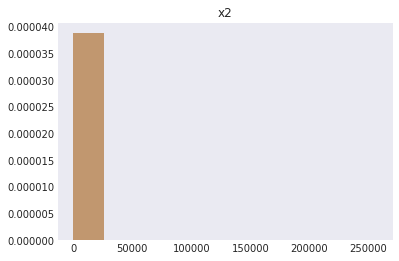

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 17 in stage 13.0 failed 1 times, most recent failure: Lost task 17.0 in stage 13.0 (TID 261, localhost, executor driver): java.lang.OutOfMemoryError: Java heap space
	at java.util.Arrays.copyOf(Arrays.java:3236)
	at java.io.ByteArrayOutputStream.grow(ByteArrayOutputStream.java:118)
	at java.io.ByteArrayOutputStream.ensureCapacity(ByteArrayOutputStream.java:93)
	at java.io.ByteArrayOutputStream.write(ByteArrayOutputStream.java:153)
	at org.apache.spark.util.ByteBufferOutputStream.write(ByteBufferOutputStream.scala:41)
	at java.io.ObjectOutputStream$BlockDataOutputStream.write(ObjectOutputStream.java:1853)
	at java.io.ObjectOutputStream.write(ObjectOutputStream.java:709)
	at org.apache.spark.util.Utils$.writeByteBuffer(Utils.scala:247)
	at org.apache.spark.scheduler.DirectTaskResult$$anonfun$writeExternal$1.apply$mcV$sp(TaskResult.scala:50)
	at org.apache.spark.scheduler.DirectTaskResult$$anonfun$writeExternal$1.apply(TaskResult.scala:48)
	at org.apache.spark.scheduler.DirectTaskResult$$anonfun$writeExternal$1.apply(TaskResult.scala:48)
	at org.apache.spark.util.Utils$.tryOrIOException(Utils.scala:1346)
	at org.apache.spark.scheduler.DirectTaskResult.writeExternal(TaskResult.scala:48)
	at java.io.ObjectOutputStream.writeExternalData(ObjectOutputStream.java:1459)
	at java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1430)
	at java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1178)
	at java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:348)
	at org.apache.spark.serializer.JavaSerializationStream.writeObject(JavaSerializer.scala:43)
	at org.apache.spark.serializer.JavaSerializerInstance.serialize(JavaSerializer.scala:100)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:454)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1602)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1590)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1589)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1589)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:831)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:831)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:831)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1823)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1772)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1761)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:642)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2034)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2055)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2074)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2099)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:939)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:938)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:162)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: java.lang.OutOfMemoryError: Java heap space
	at java.util.Arrays.copyOf(Arrays.java:3236)
	at java.io.ByteArrayOutputStream.grow(ByteArrayOutputStream.java:118)
	at java.io.ByteArrayOutputStream.ensureCapacity(ByteArrayOutputStream.java:93)
	at java.io.ByteArrayOutputStream.write(ByteArrayOutputStream.java:153)
	at org.apache.spark.util.ByteBufferOutputStream.write(ByteBufferOutputStream.scala:41)
	at java.io.ObjectOutputStream$BlockDataOutputStream.write(ObjectOutputStream.java:1853)
	at java.io.ObjectOutputStream.write(ObjectOutputStream.java:709)
	at org.apache.spark.util.Utils$.writeByteBuffer(Utils.scala:247)
	at org.apache.spark.scheduler.DirectTaskResult$$anonfun$writeExternal$1.apply$mcV$sp(TaskResult.scala:50)
	at org.apache.spark.scheduler.DirectTaskResult$$anonfun$writeExternal$1.apply(TaskResult.scala:48)
	at org.apache.spark.scheduler.DirectTaskResult$$anonfun$writeExternal$1.apply(TaskResult.scala:48)
	at org.apache.spark.util.Utils$.tryOrIOException(Utils.scala:1346)
	at org.apache.spark.scheduler.DirectTaskResult.writeExternal(TaskResult.scala:48)
	at java.io.ObjectOutputStream.writeExternalData(ObjectOutputStream.java:1459)
	at java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1430)
	at java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1178)
	at java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:348)
	at org.apache.spark.serializer.JavaSerializationStream.writeObject(JavaSerializer.scala:43)
	at org.apache.spark.serializer.JavaSerializerInstance.serialize(JavaSerializer.scala:100)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:454)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	... 1 more


----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 42834)
Traceback (most recent call last):
  File "/opt/anaconda/lib/python3.6/socketserver.py", line 317, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/opt/anaconda/lib/python3.6/socketserver.py", line 348, in process_request
    self.finish_request(request, client_address)
  File "/opt/anaconda/lib/python3.6/socketserver.py", line 361, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/opt/anaconda/lib/python3.6/socketserver.py", line 721, in __init__
    self.handle()
  File "/opt/anaconda/lib/python3.6/site-packages/pyspark-2.3.1-py3.6.egg/pyspark/accumulators.py", line 235, in handle
    num_updates = read_int(self.rfile)
  File "/opt/anaconda/lib/python3.6/site-packages/pyspark-2.3.1-py3.6.egg/pyspark/serializers.py", line 685, in read_int
    raise EOFError
EOFError
---------------------------------

In [18]:
def take_log(x):
    return np.sign(x) * np.log(np.abs(x)+0.001)

for feature in INTEGER_FEATURES[2:4]:
    val_min = float(summary[feature][3])
    val_max = float(summary[feature][4])
    bin_width = round((val_max-val_min)/10)
    bins = np.arange(val_min, val_max+bin_width, bin_width)
    val_0 = trainDF_0.select(feature).rdd.map(lambda x: x[0]).filter(lambda x: x != None)
    val_1 = trainDF_1.select(feature).rdd.map(lambda x: x[0]).filter(lambda x: x != None)
    plt.hist(val_0.collect(), bins=bins, density=True, alpha=0.5)
    plt.hist(val_1.collect(), bins=bins, density=True, alpha=0.5)
    plt.title(feature)
    plt.show()

    log_0 = val_0.map(lambda x: take_log(x))
    log_1 = val_1.map(lambda x: take_log(x))
    plt.hist(log_0.collect(), bins=10, density=True, alpha=0.5)
    plt.hist(log_1.collect(), bins=10, density=True, alpha=0.5)
    plt.title(feature+" log transform")
    plt.show()

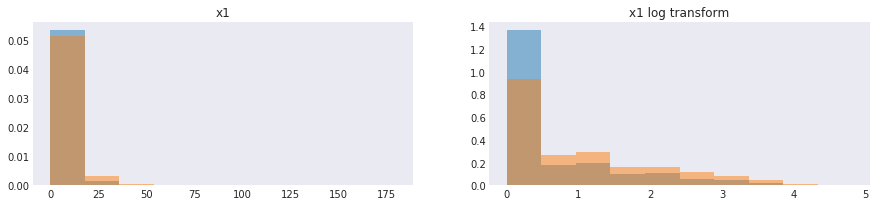

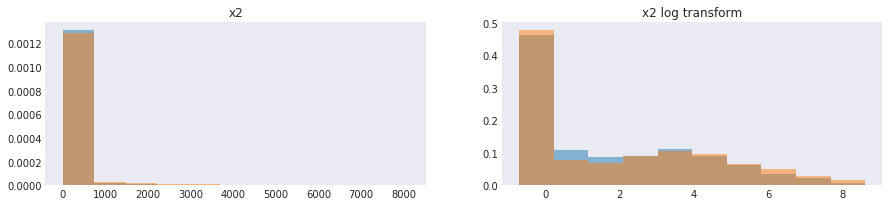

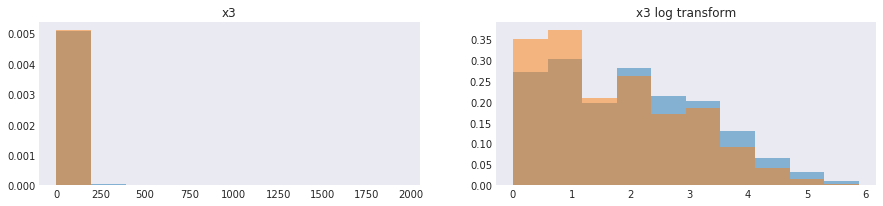

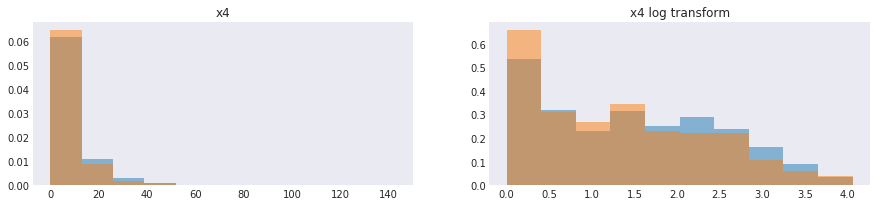

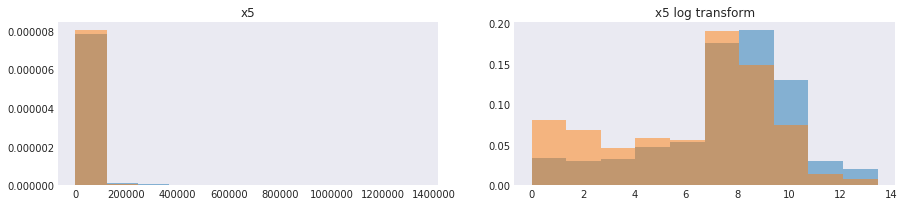

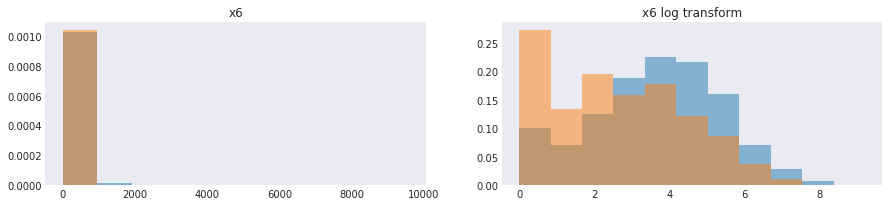

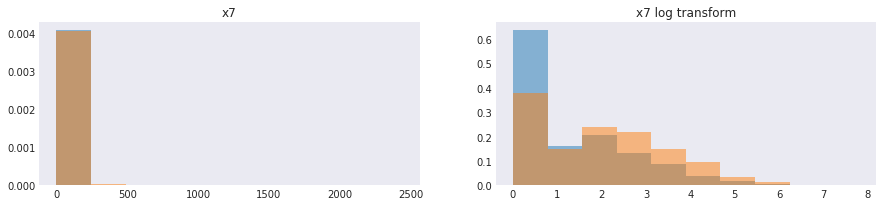

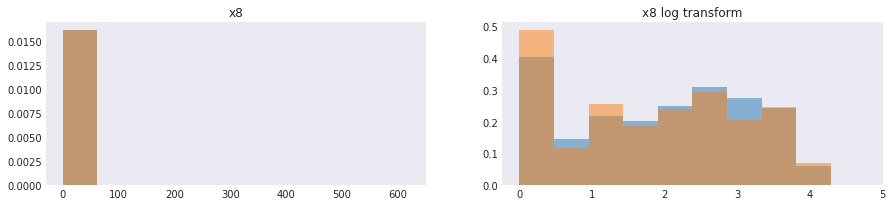

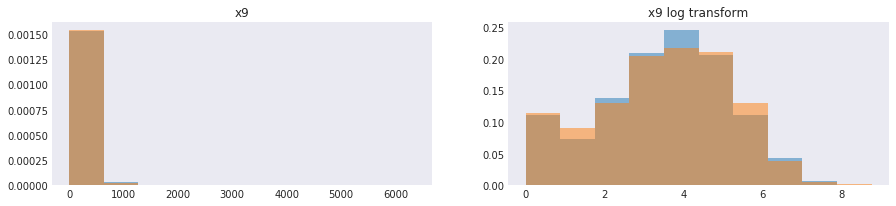

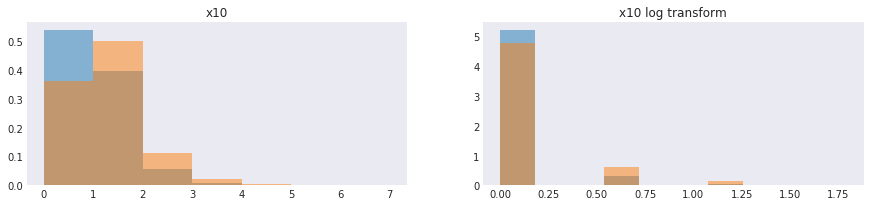

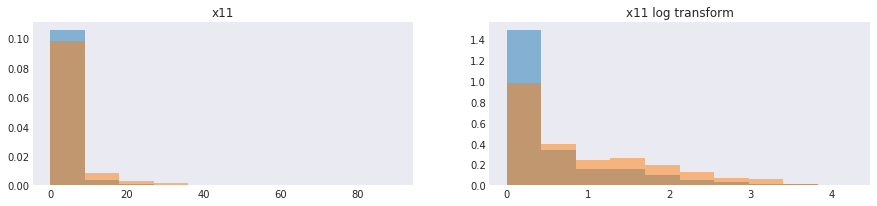

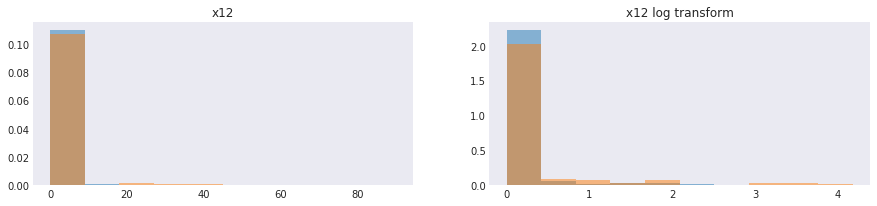

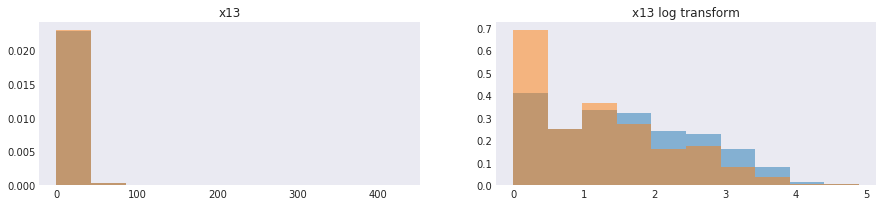

In [15]:
for feature in INTEGER_FEATURES[1:]:
    fig, ax = plt.subplots(1, 2, figsize=(15,3))
    min = sample[feature].min()
    max = sample[feature].max()
    bin_width = round((max-min)/20)
    bins = np.arange(min, max+bin_width, bin_width)
    ax[0].hist(sample[sample["y"]==0][feature].dropna(), bins=bins, density=True, alpha=0.5)
    ax[0].hist(sample[sample["y"]==1][feature].dropna(), bins=bins, density=True, alpha=0.5)
    ax[0].set_title(feature)
    
    log_0 = np.sign(sample[sample["y"]==0][feature].dropna()) * np.log(np.abs(sample[sample["y"]==0][feature].dropna())+0.001)
    log_1 = np.sign(sample[sample["y"]==1][feature].dropna()) * np.log(np.abs(sample[sample["y"]==1][feature].dropna())+0.001)
    min = log_0.min()
    max = log_1.max()
    bin_width = (max-min)/20
    bins = np.arange(min, max+bin_width, bin_width)
    ax[1].hist(log_0, bins=bins, density=True, alpha=0.5)
    ax[1].hist(log_1, bins=bins, density=True, alpha=0.5)
    ax[1].set_title(feature+" log transform")
    fig.show()

### Categorical Variables EDA

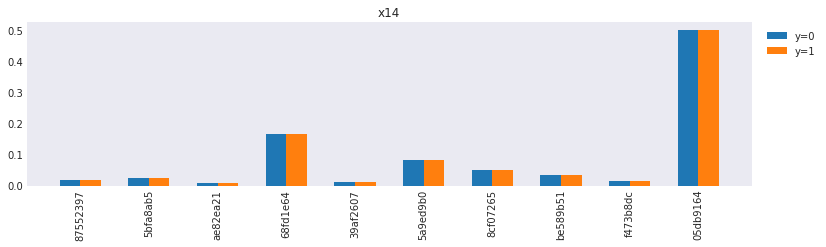

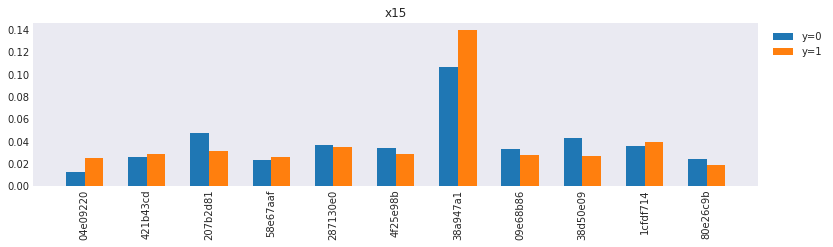

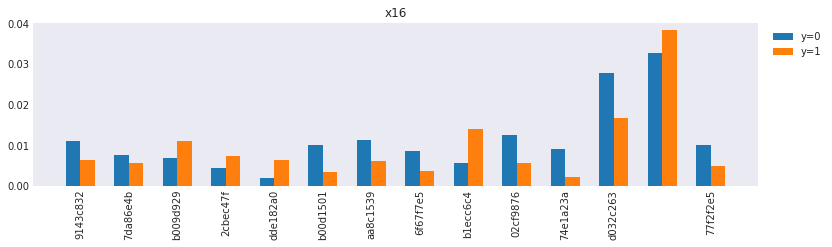

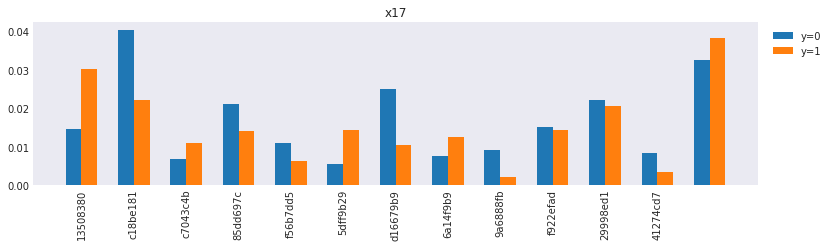

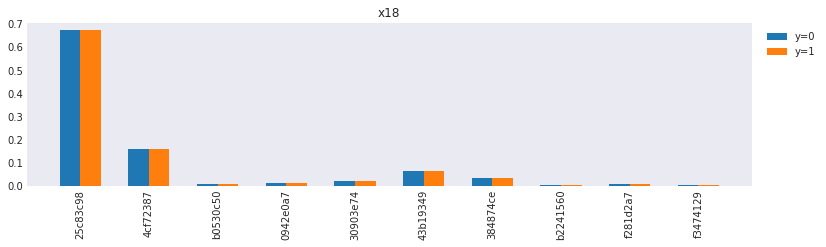

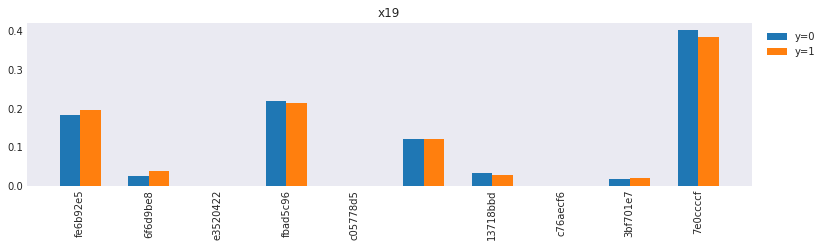

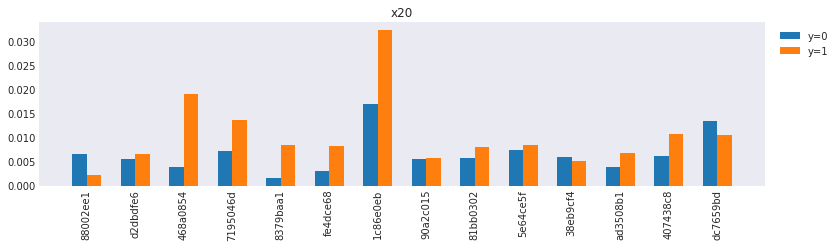

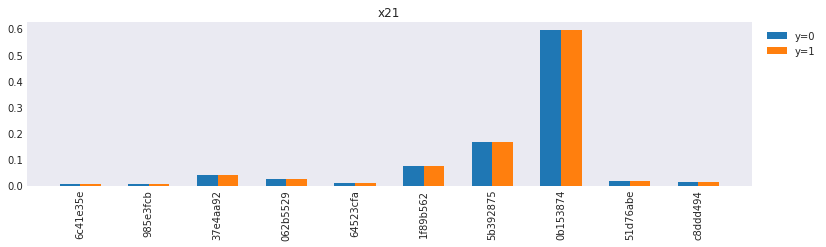

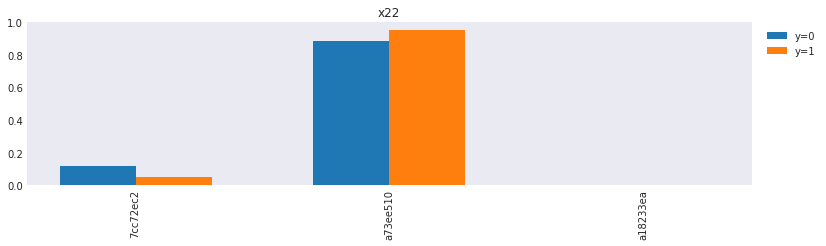

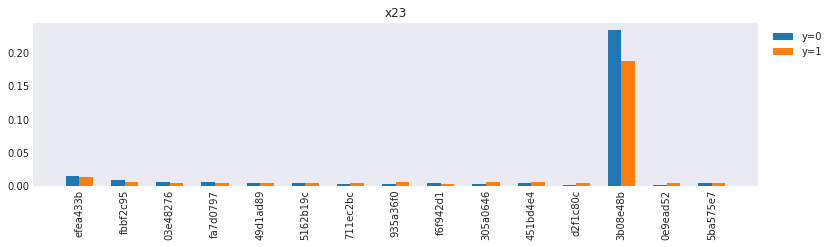

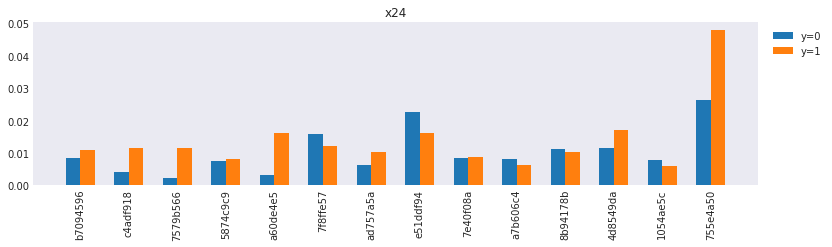

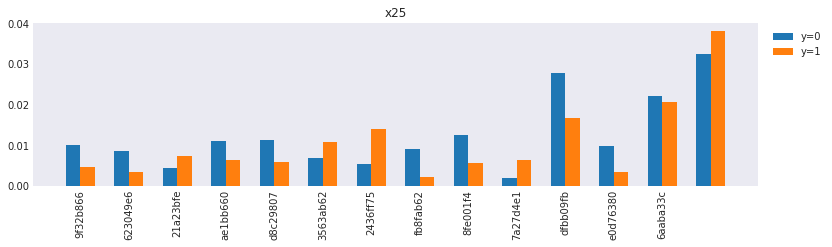

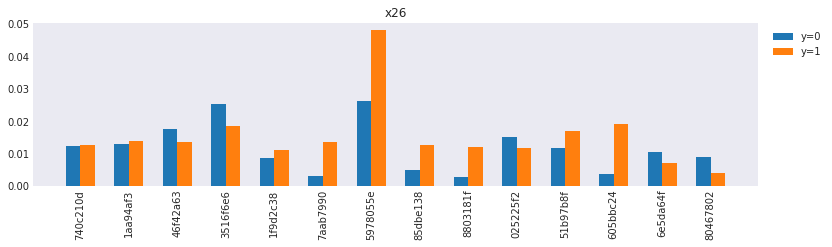

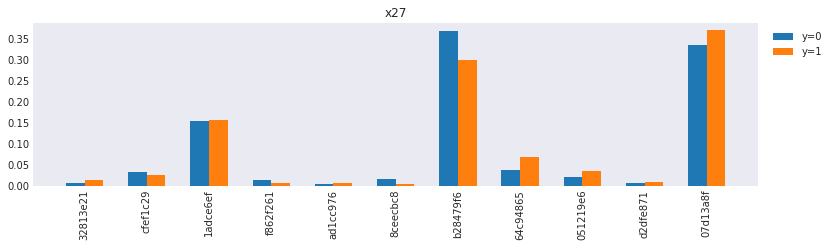

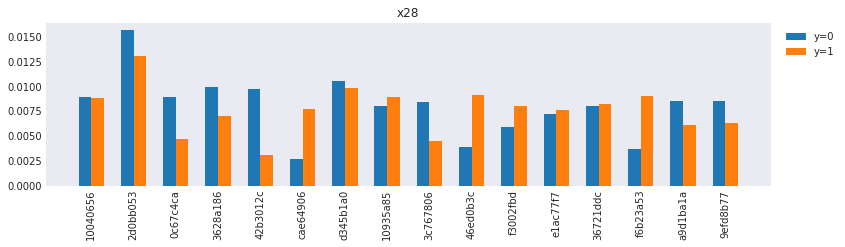

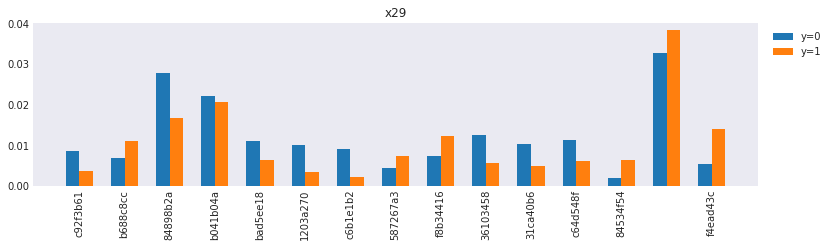

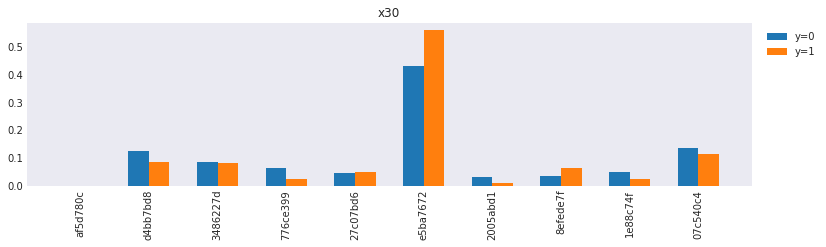

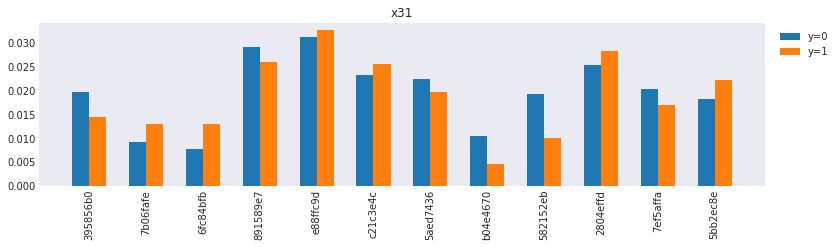

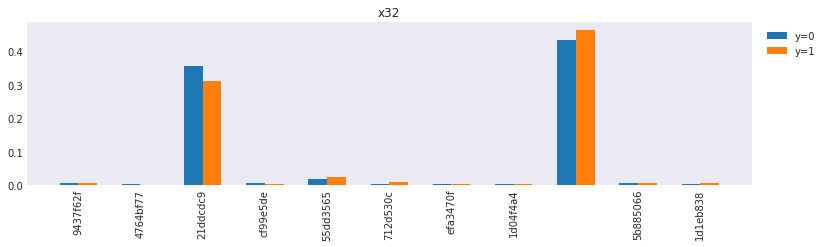

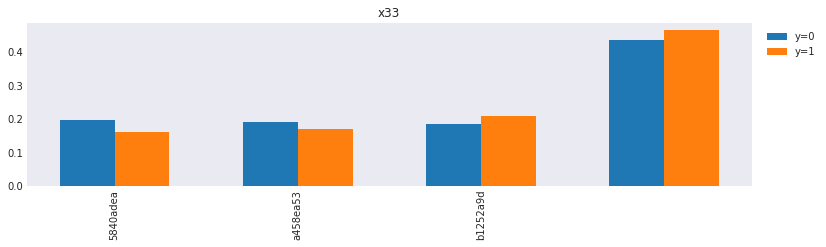

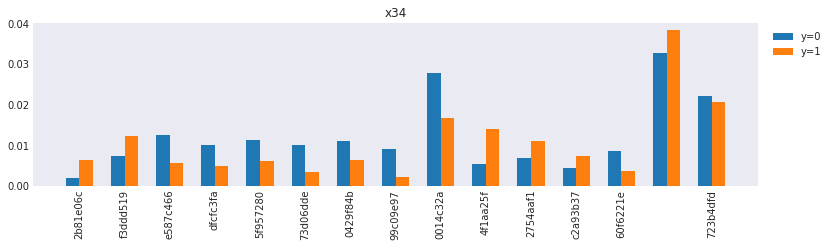

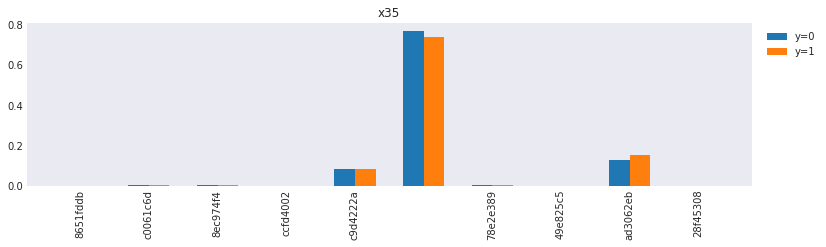

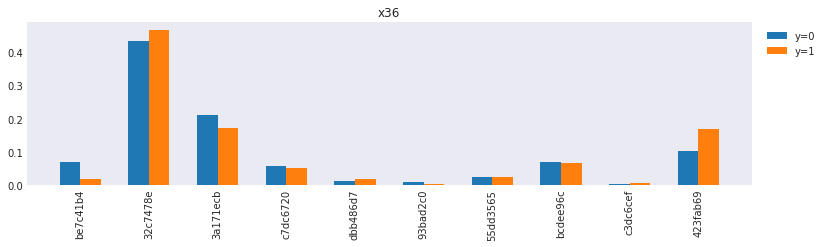

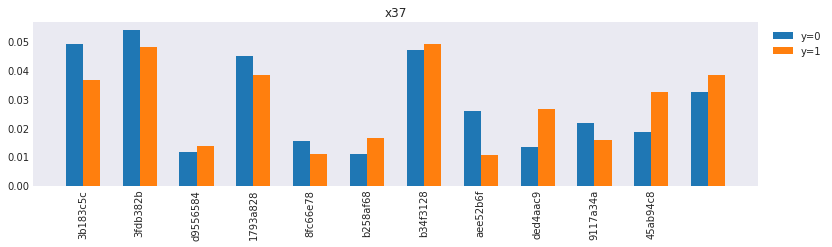

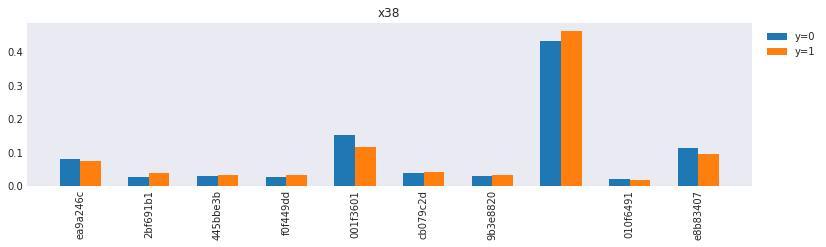

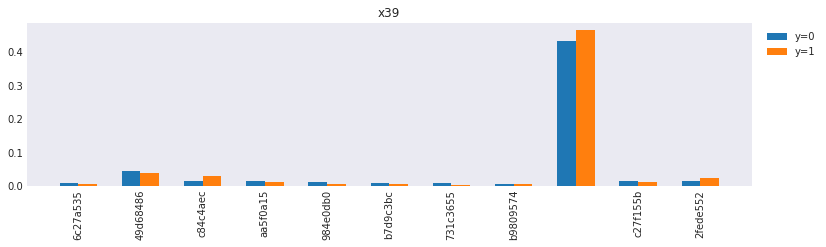


... Executed in 918.9575052261353 seconds


In [46]:
#PYSPARK VERSION - UPDATED

start = time.time()

top_all = pd.DataFrame()

for feature in CATEGORICAL_FEATURES:

    #find the feature's value frequencies for class 0
    values_0_list = trainDF_0.groupBy(feature).agg({"*": "count"})
    values_0_rdd = values_0_list.rdd.map(lambda x: (x[0], (x[1], 0)))

    #find the feature's value frequencies for class 1
    values_1_list = trainDF_1.groupBy(feature).agg({"*": "count"})
    values_1_rdd = values_1_list.rdd.map(lambda x: (x[0], (0, x[1])))

    #concatenate the class 0 and class 1 value frequencies
    all_values = sc.union([values_0_rdd, values_1_rdd]).reduceByKey(lambda x,y: (x[0]+y[0], x[1]+y[1]))
    all_values = all_values.map(lambda x: (x[0], x[1][0], x[1][1]))

    #find the top 10 features for each class
    top_0 = all_values.takeOrdered(10, lambda x: -x[1])
    top_1 = all_values.takeOrdered(10, lambda x: -x[2])
    top_both = pd.DataFrame(list(set(top_0)|set(top_1)))
    top_both.set_index(0, inplace=True)
    top_both.columns = ["y=0","y=1"]
    top_both["y=0"] = top_both["y=0"]/train_count_0
    top_both["y=1"] = top_both["y=1"]/train_count_1
    top_both["difference"] = np.abs(top_both["y=0"]-top_both["y=1"])
    top_both["feature"] = feature
    top_all = pd.concat([top_all,top_both],axis=0)

    #create a grouped barplot
    bar_width = 0.3
    bar_loc = np.arange(len(top_both.index))+1
    fig, ax = plt.subplots(figsize=(13, 3))
    plt.bar(bar_loc, top_both["y=0"].values, label="y=0", width=bar_width)
    plt.bar(bar_loc+bar_width, top_both["y=1"].values, label="y=1", width=bar_width)
    ax.set_xticks(bar_loc + bar_width / 2)
    ax.set_xticklabels(top_both.index)
    ax.legend(loc="upper right", bbox_to_anchor=(1.1, 1))
    plt.xticks(rotation=90)
    plt.title(feature)
    plt.show()
    
print(f"\n... Executed in {time.time() - start} seconds")

In [47]:
#filter for the feature values that are present in 10% of samples for either class
#and have at least 1% difference between the classes
top_include = top_all[((top_all["y=0"]>0.1)|(top_all["y=1"]>0.1))&(top_all["difference"]>0.01)]
top_include

,y=0,y=1,difference,feature
0,,,,
38a947a1,0.105985,0.138964,0.032979,x15
fe6b92e5,0.182927,0.195395,0.012468,x19
7e0ccccf,0.400310,0.384687,0.015622,x19
7cc72ec2,0.118799,0.049581,0.069218,x22
a73ee510,0.881002,0.950346,0.069343,x22
3b08e48b,0.233274,0.187667,0.045607,x23
b28479f6,0.367317,0.298440,0.068877,x27
07d13a8f,0.333741,0.369656,0.035915,x27
d4bb7bd8,0.125681,0.083038,0.042643,x30


In [54]:
#top_include.to_csv("top_include.csv")
top_include = pd.read_csv("top_include.csv")
top_include.set_index("0", inplace=True, drop=True)
top_include

,y=0,y=1,difference,feature
0,,,,
38a947a1,0.105985,0.138964,0.032979,x15
fe6b92e5,0.182927,0.195395,0.012468,x19
7e0ccccf,0.400310,0.384687,0.015622,x19
7cc72ec2,0.118799,0.049581,0.069218,x22
a73ee510,0.881002,0.950346,0.069343,x22
3b08e48b,0.233274,0.187667,0.045607,x23
b28479f6,0.367317,0.298440,0.068877,x27
07d13a8f,0.333741,0.369656,0.035915,x27
d4bb7bd8,0.125681,0.083038,0.042643,x30


In [55]:
cat_feat_include = list(top_include["feature"].unique())
cat_feat_include

['x15',
 'x19',
 'x22',
 'x23',
 'x27',
 'x30',
 'x32',
 'x33',
 'x35',
 'x36',
 'x38',
 'x39']

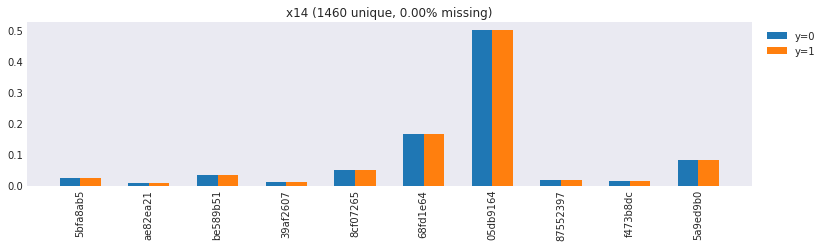

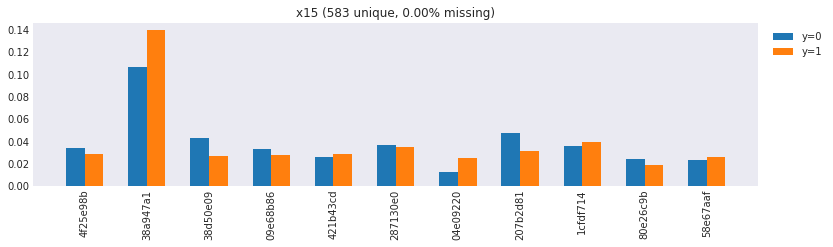

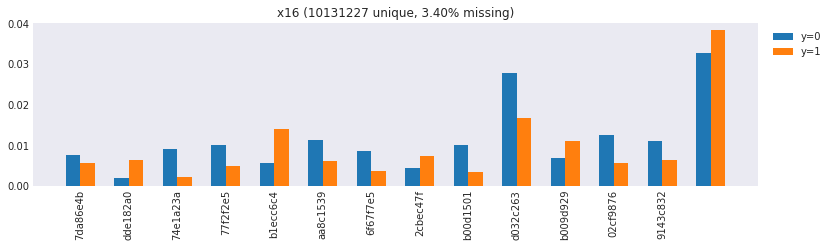

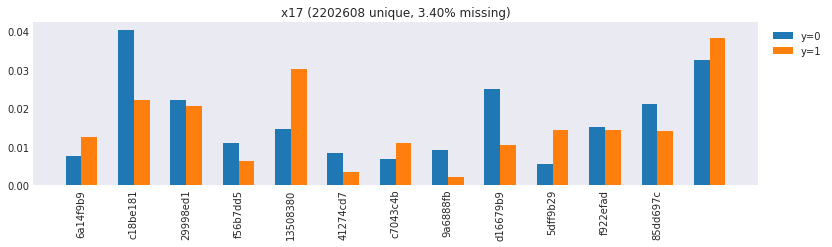

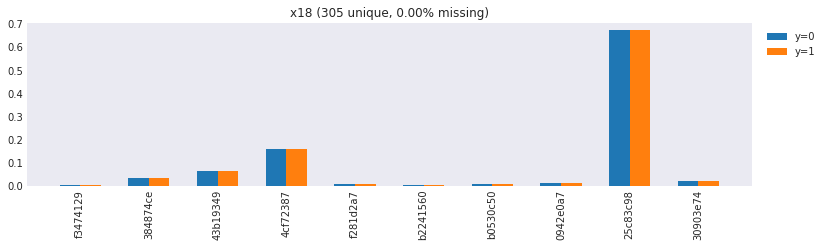

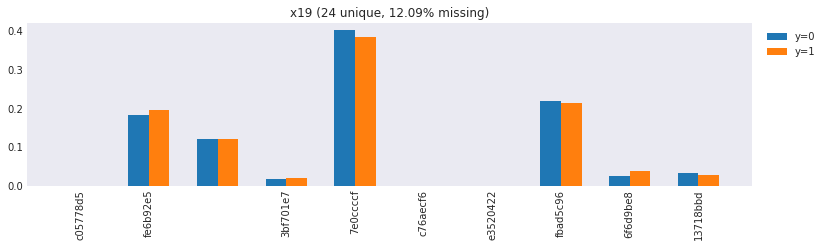

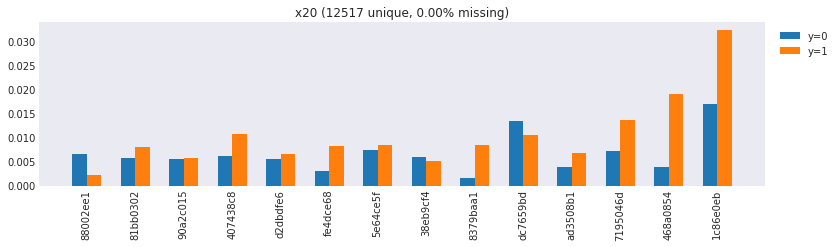

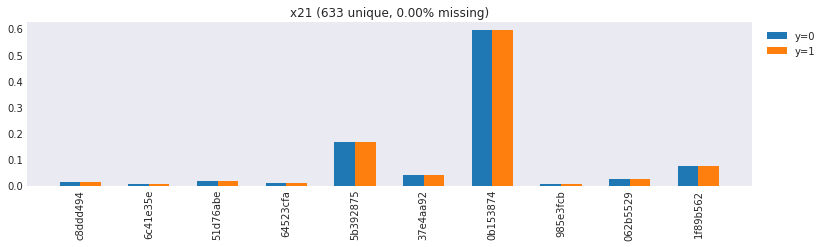

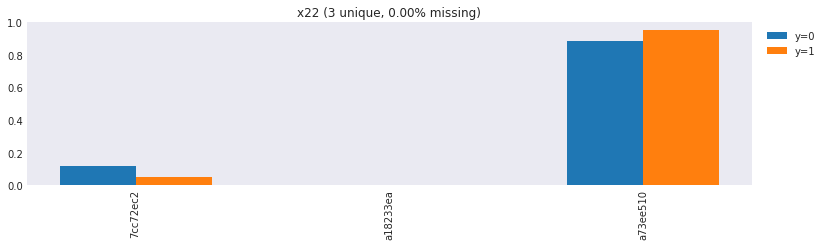

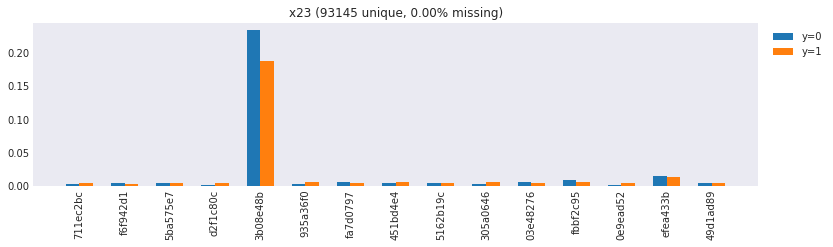

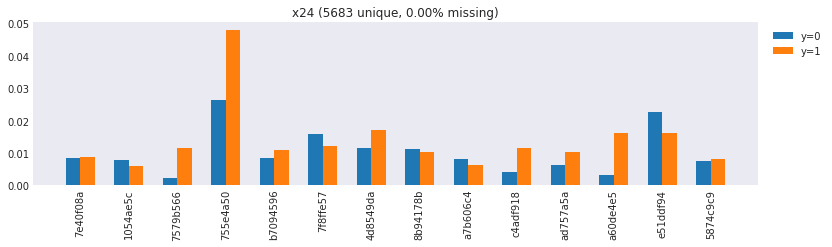

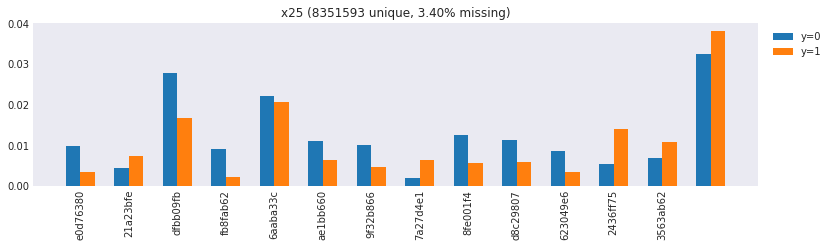

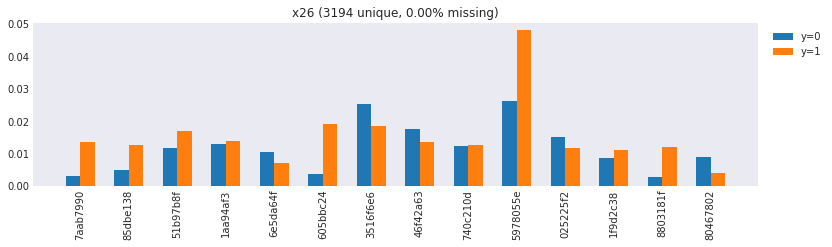

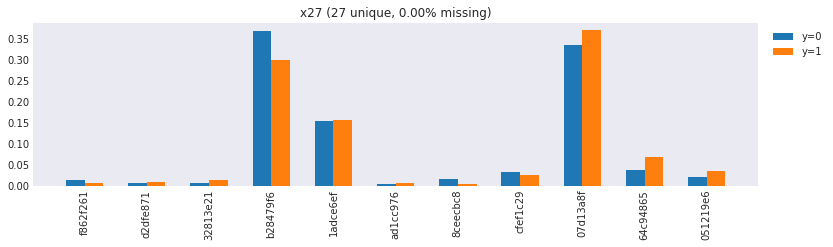

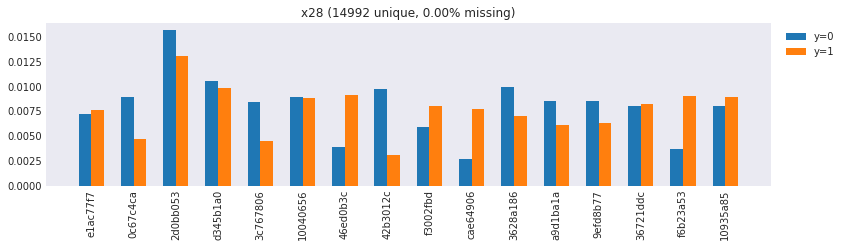

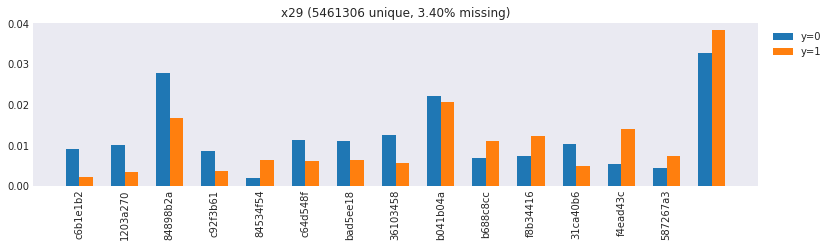

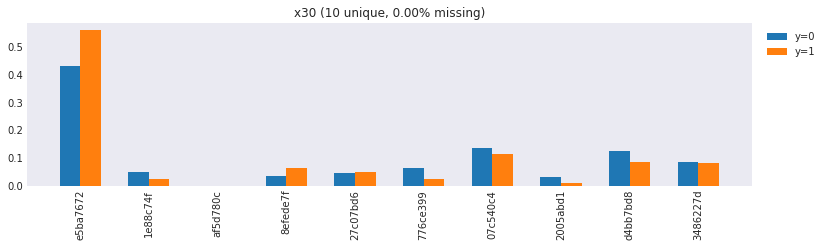

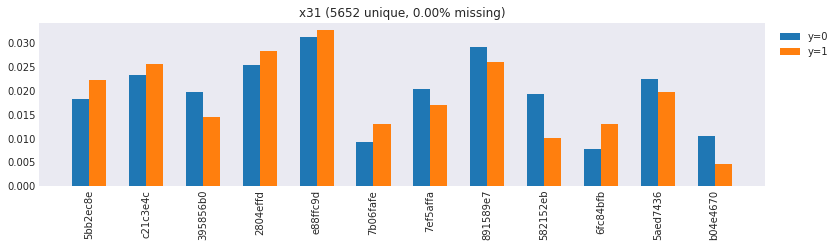

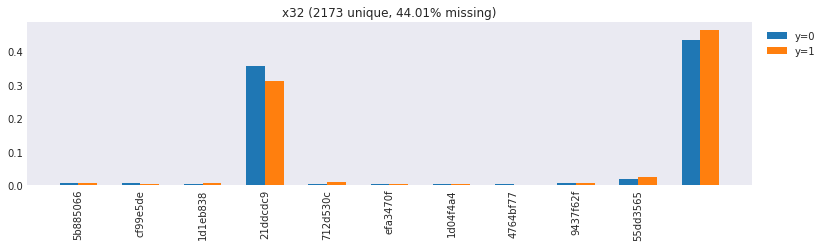

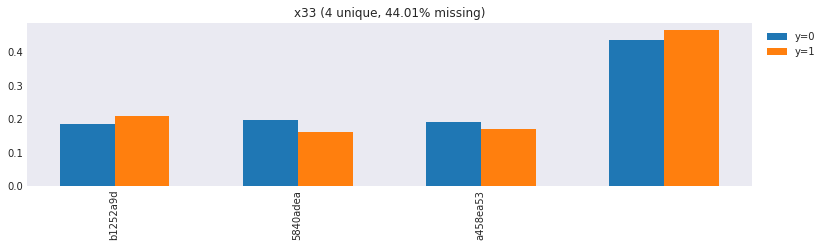

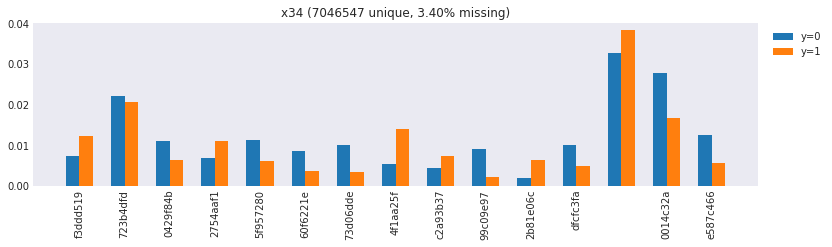

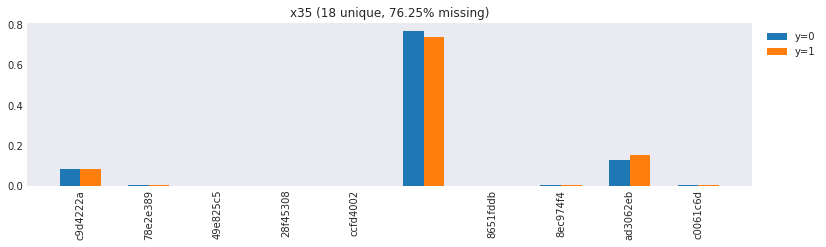

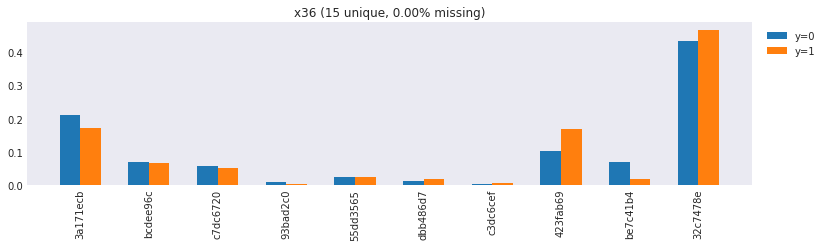

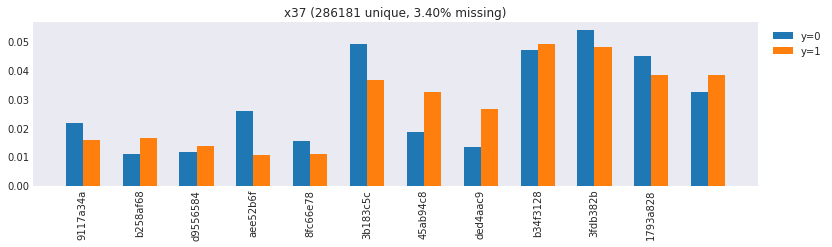

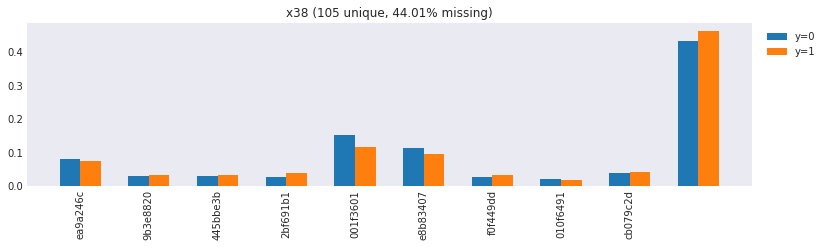

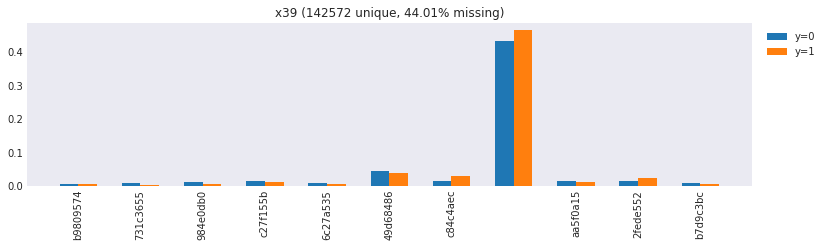

In [237]:
#PYSPARK VERSION OLD

start = time.time()

for feature in CATEGORICAL_FEATURES:

    #find the feature's value frequencies for class 0
    values_0_list = trainDF_0.groupBy(feature).agg({"*": "count"})
    values_0_rdd = values_0_list.rdd.map(lambda x: (x[0], (x[1], 0)))

    #find the feature's value frequencies for class 1
    values_1_list = trainDF_1.groupBy(feature).agg({"*": "count"})
    values_1_rdd = values_1_list.rdd.map(lambda x: (x[0], (0, x[1])))

    #concatenate the class 0 and class 1 value frequencies
    all_values = sc.union([values_0_rdd, values_1_rdd]).reduceByKey(lambda x,y: (x[0]+y[0], x[1]+y[1]))
    all_values = all_values.map(lambda x: (x[0], x[1][0], x[1][1]))

    #find the top 10 features for each class
    top_0 = all_values.takeOrdered(10, lambda x: -x[1])
    top_1 = all_values.takeOrdered(10, lambda x: -x[2])
    top_both = pd.DataFrame(list(set(top_0)|set(top_1)))
    top_both.set_index(0, inplace=True)
    top_both.columns = ["y=0","y=1"]

    #create a grouped barplot
    bar_width = 0.3
    bar_loc = np.arange(len(top_both.index))+1
    fig, ax = plt.subplots(figsize=(13, 3))
    plt.bar(bar_loc, top_both["y=0"].values/train_count_0, label="y=0", width=bar_width)
    plt.bar(bar_loc+bar_width, top_both["y=1"].values/train_count_1, label="y=1", width=bar_width)
    ax.set_xticks(bar_loc + bar_width / 2)
    ax.set_xticklabels(top_both.index)
    ax.legend(loc="upper right", bbox_to_anchor=(1.1, 1))
    plt.xticks(rotation=90)

    #find number of unique and missing values for the feature
    num_unique = all_values.count()
    missing = all_values.filter(lambda x: x[0]=="").collect()
    if missing == []:
        missing_0, missing_1 = 0, 0
    else:
        missing_0, missing_1 = missing[0][1], missing[0][2]
    percent_missing = ((missing_0 + missing_1)/train_count) * 100
    plt.title("{} ({} unique, {:0.2f}% missing)".format(feature, num_unique, percent_missing))
    plt.title(feature)
    plt.show()
    
print(f"\n... Executed in {time.time() - start} seconds")

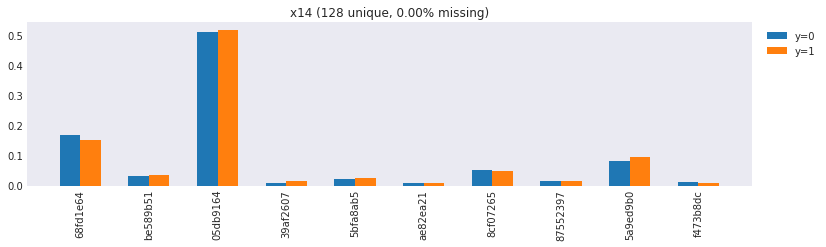

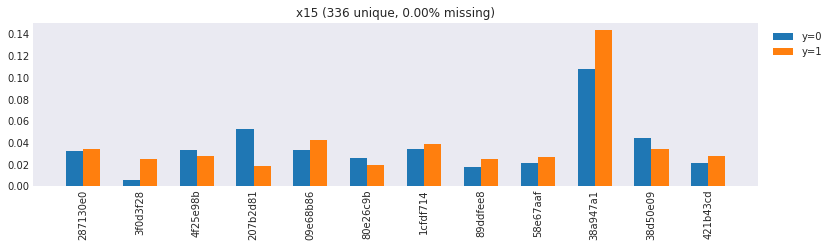

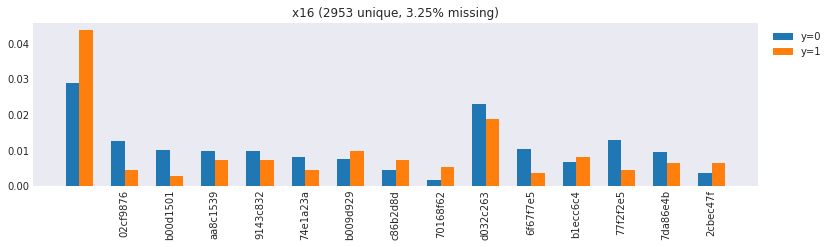

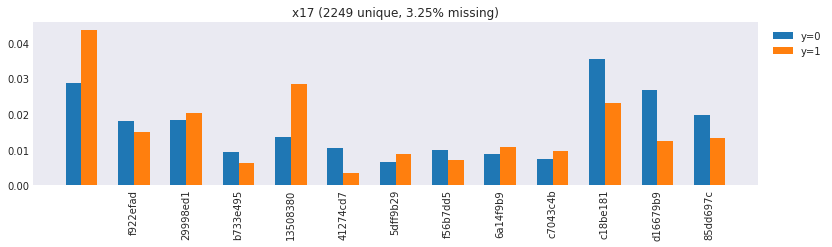

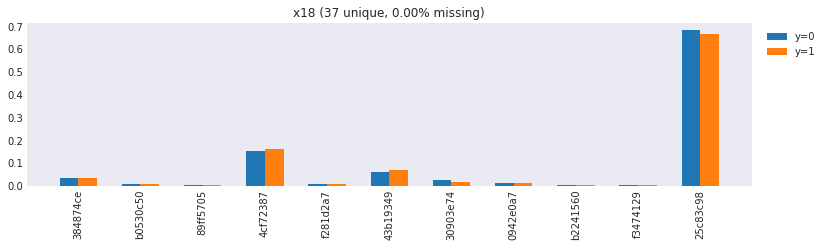

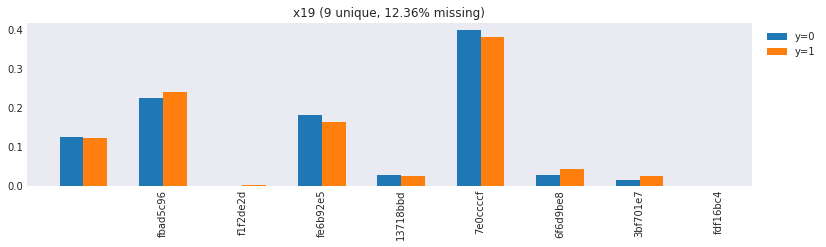

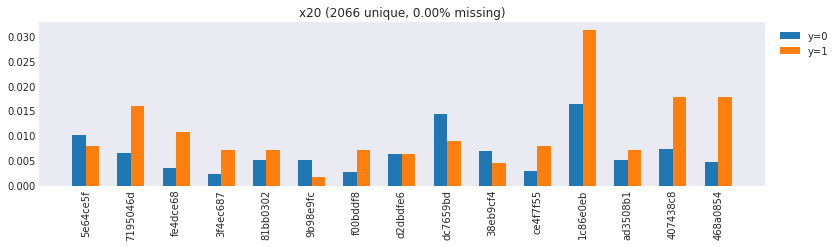

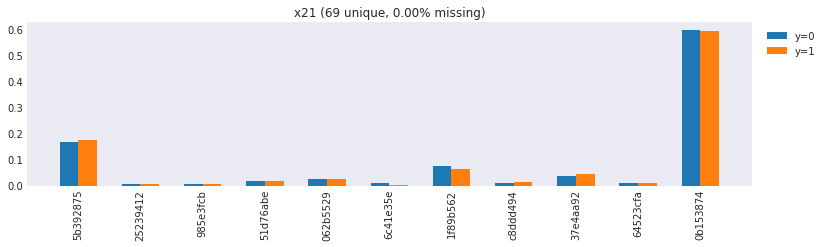

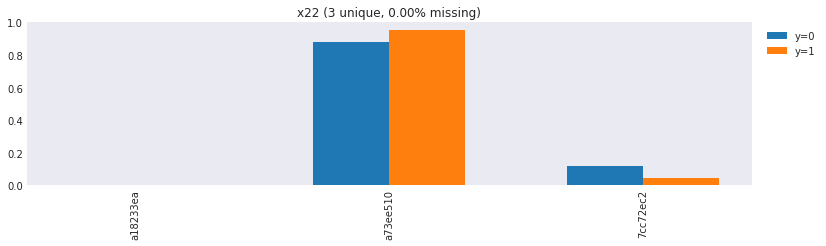

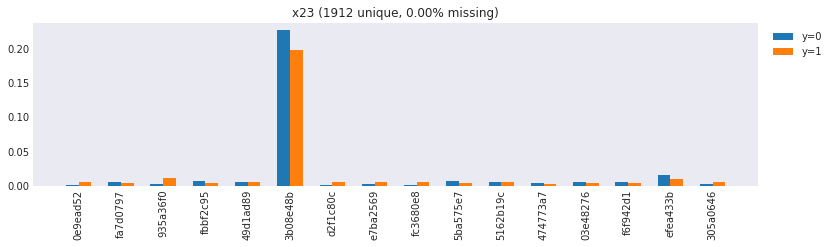

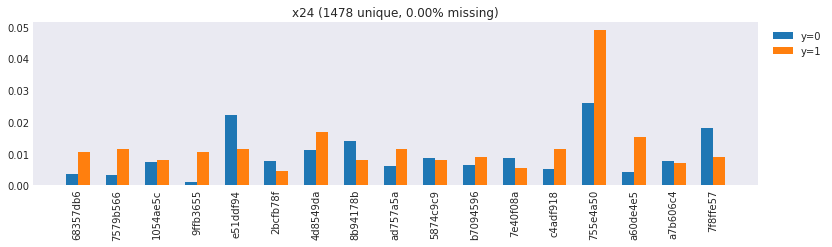

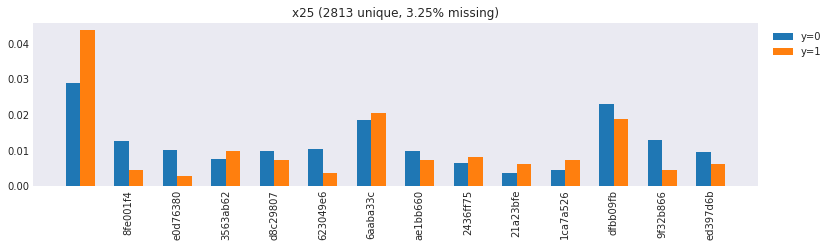

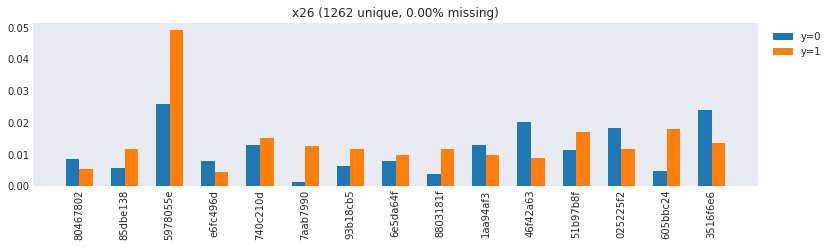

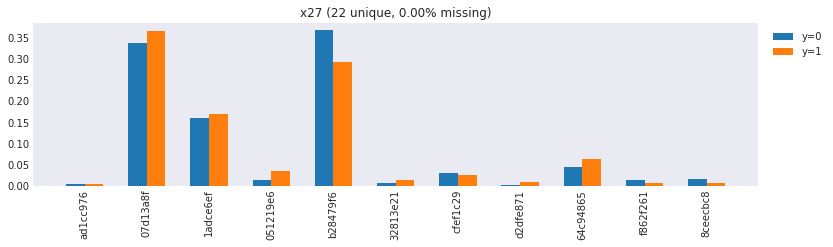

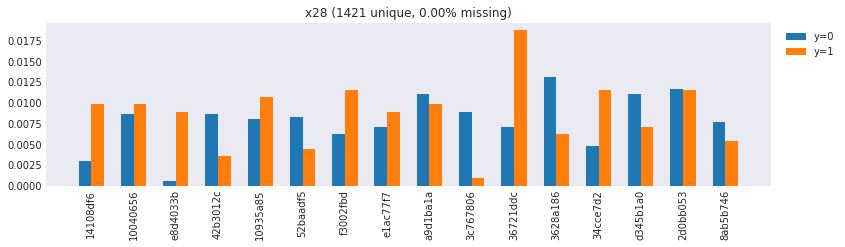

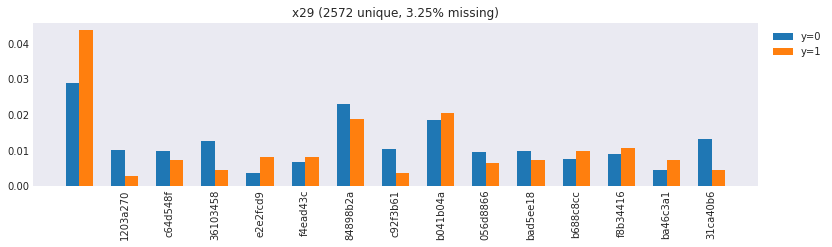

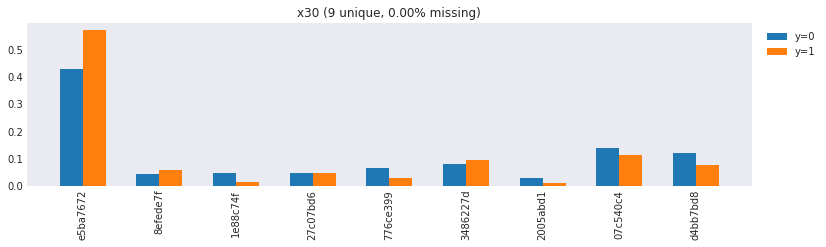

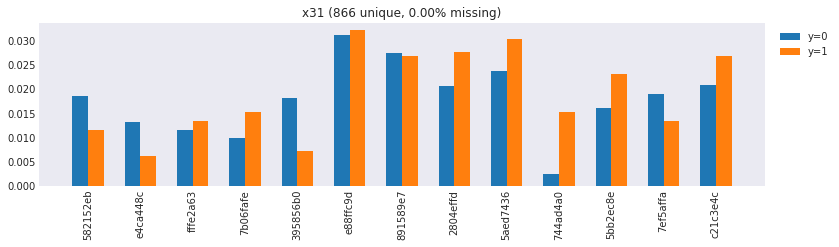

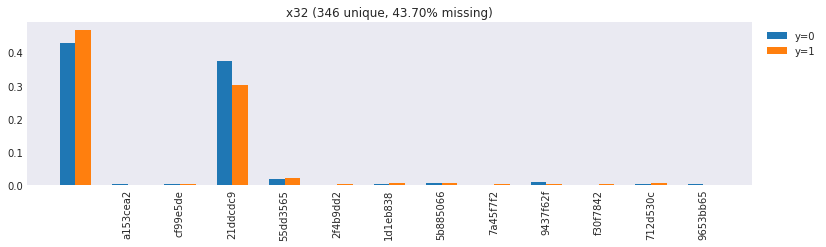

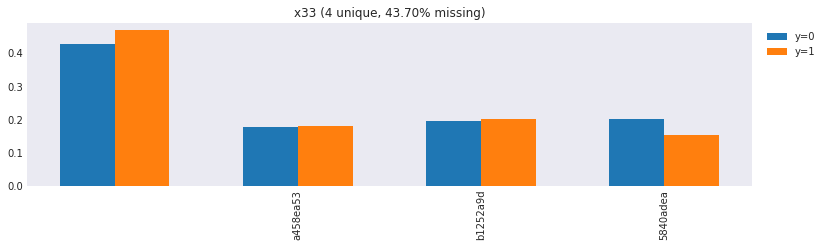

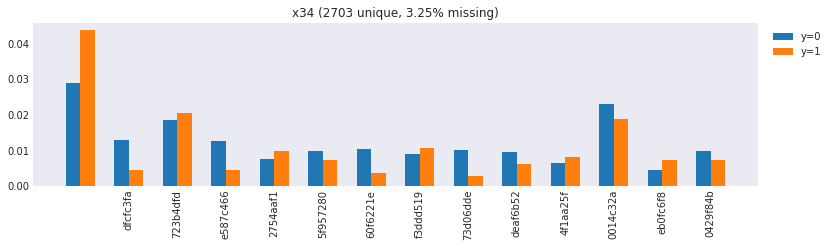

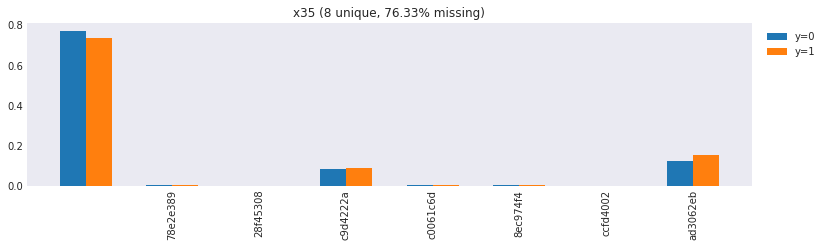

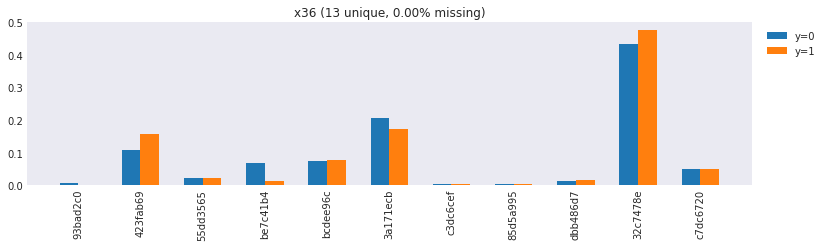

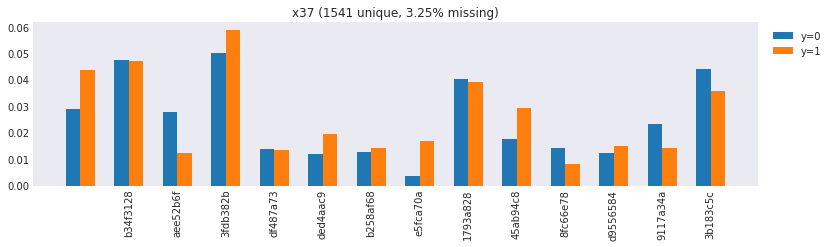

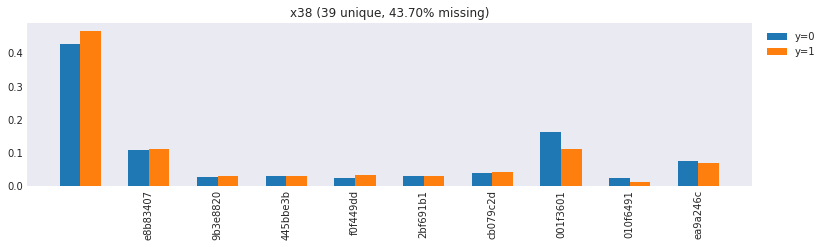

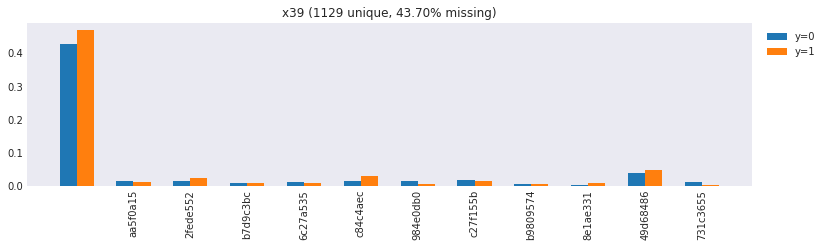

In [136]:
#EDA FOR SAMPLE OF DATA USING PANDAS

#find number of examples in each class and in total
n_samples_0 = (sample[sample["y"]==0]).shape[0]
n_samples_1 = (sample[sample["y"]==1]).shape[0]
num_sample = sample.shape[0]

for feature in CATEGORICAL_FEATURES:
    
    #find the value frequencies of the feature for those in class 0 and class 1
    values_0 = sample[sample["y"]==0][feature].value_counts()/n_samples_0
    values_1 = sample[sample["y"]==1][feature].value_counts()/n_samples_1
    
    #find the top 10 most frequent values from both classes
    all_values = pd.DataFrame([values_0,values_1]).T
    all_values.columns = ["y=0","y=1"]
    all_values.sort_values("y=0",inplace=True,ascending=False)
    top_0 = set(all_values[0:10].index)
    all_values.sort_values("y=1",inplace=True,ascending=False)
    top_1 = set(all_values[0:10].index)
    top_both = all_values.T[list(top_0|top_1)].T
    
    #create a grouped barplot
    bar_width = 0.3
    bar_loc = np.arange(len(top_both.index))+1
    fig, ax = plt.subplots(figsize=(13, 3))
    plt.bar(bar_loc, top_both["y=0"].values, label="y=0", width=bar_width)
    plt.bar(bar_loc+bar_width, top_both["y=1"].values, label="y=1", width=bar_width)
    ax.set_xticks(bar_loc + bar_width / 2)
    ax.set_xticklabels(top_both.index)
    ax.legend(loc="upper right", bbox_to_anchor=(1.1, 1))
    plt.xticks(rotation=90)
    
    #find number of unique and missing values for the feature
    num_unique = len(sample[feature].unique())
    percent_missing = (len(sample[feature][sample[feature]==""])/num_sample)*100
    plt.title("{} ({} unique, {:0.2f}% missing)".format(feature, num_unique, percent_missing))
    plt.show()

# Preprocessing

In [15]:
trainDF.take(1)

[Row(y=0.0, x1=1.0, x2=-1.0, x3=5.0, x4=3.0, x5=5.0, x6=3.0, x7=1.0, x8=3.0, x9=3.0, x10=1.0, x11=1.0, x12=None, x13=3.0, x14='8cf07265', x15='65265295', x16='bf61fc9a', x17='db9c39b1', x18='4cf72387', x19='7e0ccccf', x20='48db53e5', x21='0b153874', x22='a73ee510', x23='041560b6', x24='fe1bd1df', x25='bc6454e7', x26='3787a7a6', x27='07d13a8f', x28='b30b312f', x29='cbec8e09', x30='d4bb7bd8', x31='abad9dca', x32='21ddcdc9', x33='b1252a9d', x34='42d9424d', x35='', x36='423fab69', x37='e7540df6', x38='9b3e8820', x39='5103b5f2')]

### Impute

In [34]:
def imputeValues(df, dftest):
    
    # Impute numerical features
    for col in INTEGER_FEATURES[1:]:
        mean = df.select(col).agg({col:'mean'}).collect()[0][0]
        print(f"Column {col} has mean {mean}")
        
        #impute
        df = df.withColumn(col, F.when(df[col].isNull(), mean).otherwise(df[col]))
        dftest = dftest.withColumn(col, F.when(dftest[col].isNull(), mean).otherwise(dftest[col]))
        
        #log transform all features except x10
        if col != "x10":
            df = df.withColumn(col, (F.signum(df[col]) * F.log(F.abs(df[col])+0.001)))
            dftest = dftest.withColumn(col, F.signum(dftest[col]) * F.log(F.abs(dftest[col])+0.001))
            
#    print("Successfully Imputed and Transformed Numerical Values")

#     # Impute categorical features
#     for col in cat_feat_include:
#         mostCommon = df.select(col).groupby(col).count()\
#                             .orderBy('count', ascending=False) \
#                             .limit(1).collect()[0][0]
#         if mostCommon == "":
#             mostCommon = "EMPTY"
        
#         print(f"Column {col} has most common {mostCommon}")
        
#         df = df.withColumn(col, F.when((df[col].isNull() | (df[col] == '')), mostCommon) \
#                                 .otherwise(df[col]))
        
#         dftest = dftest.withColumn(col, F.when((dftest[col].isNull() | (dftest[col] == '') | (~dftest[col].isin(distinctDict[col]))), mostCommon) \
#                         .otherwise(dftest[col]))
#     print("Successfully Imputed Categorical Values")
    
#     # Assure there is no missing values
#     for col in INTEGER_FEATURES[1:] + cat_feat_include:
#         assert df.filter(df[col].isNull()).count() == 0, f"Column {col} contains NULL value(s)"
#         assert df.filter(df[col] == '').count() == 0, f"Column {col} contains empty string(s)"
    
#         assert dftest.filter(dftest[col].isNull()).count() == 0, f"Column {col} contains NULL value(s)"
#         assert dftest.filter(dftest[col] == '').count() == 0, f"Column {col} contains empty string(s)"
    
#     print("Successfully Imputed All Values and Passed Tests")
    return (df, dftest)

In [35]:
# Count Number of Unique Values
# start = time.time()
# distinct = []
# for col in CATEGORICAL_FEATURES:
#     distinct.append(set(trainDF.select(col).distinct().rdd.map(lambda x: x[0]).collect()))
# print(f"\n... Executed in {time.time() - start} seconds")
# distinctDict = dict((k, v) for k, v  in zip(CATEGORICAL_FEATURES, distinct))

In [36]:
start = time.time()
trainDF, testDF = imputeValues(trainDF, testDF)
print(f"\n... Executed in {time.time() - start} seconds")

Column x1 has mean 3.5024133170754044
Column x2 has mean 105.84841979766546
Column x3 has mean 26.913041020611274
Column x4 has mean 7.322680248873305
Column x5 has mean 18538.991664871523
Column x6 has mean 116.06185085211598
Column x7 has mean 16.333130032135028
Column x8 has mean 12.517042137556713
Column x9 has mean 106.1098234380509
Column x10 has mean 0.6175294977722137
Column x11 has mean 2.7328343170173044
Column x12 has mean 0.9910356287721244
Column x13 has mean 8.217461161174054

... Executed in 48.94634413719177 seconds


In [33]:
trainDF.take(1)

[Row(y=0.0, x1=-6.214857963094057, x2=-0.0009995003330834232, x3=1.6096378924367667, x4=1.09894556645823, x5=1.6096378924367667, x6=1.09894556645823, x7=0.0009995003330834232, x8=1.09894556645823, x9=1.09894556645823, x10=1.0, x11=0.0009995003330834232, x12=-0.007996256241300147, x13=1.09894556645823, x14='8cf07265', x15='65265295', x16='bf61fc9a', x17='db9c39b1', x18='4cf72387', x19='7e0ccccf', x20='48db53e5', x21='0b153874', x22='a73ee510', x23='041560b6', x24='fe1bd1df', x25='bc6454e7', x26='3787a7a6', x27='07d13a8f', x28='b30b312f', x29='cbec8e09', x30='d4bb7bd8', x31='abad9dca', x32='21ddcdc9', x33='b1252a9d', x34='42d9424d', x35='', x36='423fab69', x37='e7540df6', x38='9b3e8820', x39='5103b5f2')]

In [37]:
def bucketValues(df, dftest):
    for col in cat_feat_include:
        values_keep = set(top_include[top_include["feature"]==col].index)
        df = df.withColumn(col, F.when(df[col].isin(values_keep), df[col]).otherwise("OTHER"))
        dftest = dftest.withColumn(col, F.when(dftest[col].isin(values_keep), dftest[col]).otherwise("OTHER"))
    return (df, dftest)

In [38]:
start = time.time()
trainDF, testDF = bucketValues(trainDF, testDF)
print(f"\n... Executed in {time.time() - start} seconds")


... Executed in 0.5973122119903564 seconds


In [51]:
trainDF.take(1)

[Row(y=0.0, x1=-6.214857963094057, x2=-0.0009995003330834232, x3=1.6096378924367667, x4=1.09894556645823, x5=1.6096378924367667, x6=1.09894556645823, x7=0.0009995003330834232, x8=1.09894556645823, x9=1.09894556645823, x10=1.0, x11=0.0009995003330834232, x12=-0.007996256241300147, x13=1.09894556645823, x14='8cf07265', x15='OTHER', x16='bf61fc9a', x17='db9c39b1', x18='4cf72387', x19='7e0ccccf', x20='48db53e5', x21='0b153874', x22='a73ee510', x23='OTHER', x24='fe1bd1df', x25='bc6454e7', x26='3787a7a6', x27='07d13a8f', x28='b30b312f', x29='cbec8e09', x30='d4bb7bd8', x31='abad9dca', x32='21ddcdc9', x33='b1252a9d', x34='42d9424d', x35='', x36='423fab69', x37='e7540df6', x38='OTHER', x39='OTHER')]

In [39]:
def emptyValues(df, dftest):
    for col in cat_feat_include:
        df = df.withColumn(col, F.when(df[col] == '', "EMPTY").otherwise(df[col]))
        dftest = dftest.withColumn(col, F.when(dftest[col] == '', "EMPTY").otherwise(dftest[col]))
    return (df, dftest)

In [40]:
start = time.time()
trainDF, testDF = emptyValues(trainDF, testDF)
print(f"\n... Executed in {time.time() - start} seconds")


... Executed in 0.23761463165283203 seconds


### Integer Columns

In [36]:
# start = time.time()
# trainDF = sqlContext.read.parquet('trainImputed.parquet')
# testDF = sqlContext.read.parquet('testImputed.parquet')
# print(f"\n... Executed in {time.time() - start} seconds")


... Executed in 0.07823657989501953 seconds


In [41]:
start = time.time()

assembler = VectorAssembler(inputCols = INTEGER_FEATURES[1:], outputCol = 'integerFeatures')
trainDF = assembler.transform(trainDF)
testDF = assembler.transform(testDF)

print(f"\n... Executed in {time.time() - start} seconds")


... Executed in 0.10049128532409668 seconds


In [42]:
trainDF.take(1)

[Row(y=0.0, x1=0.0009995003330834232, x2=-0.0009995003330834232, x3=1.6096378924367667, x4=1.09894556645823, x5=1.6096378924367667, x6=1.09894556645823, x7=0.0009995003330834232, x8=1.09894556645823, x9=1.09894556645823, x10=1.0, x11=0.0009995003330834232, x12=-0.007996256241300147, x13=1.09894556645823, x14='8cf07265', x15='OTHER', x16='bf61fc9a', x17='db9c39b1', x18='4cf72387', x19='OTHER', x20='48db53e5', x21='0b153874', x22='OTHER', x23='OTHER', x24='fe1bd1df', x25='bc6454e7', x26='3787a7a6', x27='OTHER', x28='b30b312f', x29='cbec8e09', x30='OTHER', x31='abad9dca', x32='OTHER', x33='OTHER', x34='42d9424d', x35='OTHER', x36='OTHER', x37='e7540df6', x38='OTHER', x39='OTHER', integerFeatures=DenseVector([0.001, -0.001, 1.6096, 1.0989, 1.6096, 1.0989, 0.001, 1.0989, 1.0989, 1.0, 0.001, -0.008, 1.0989]))]

In [38]:
# featuresToDrop = featuresToDrop.union(set(INTEGER_FEATURES[1:]))

In [39]:
# # Drop the Integer Columns
# trainDF = trainDF.select([c for c in trainDF.columns if c not in featuresToDrop])
# testDF = testDF.select([c for c in testDF.columns if c not in featuresToDrop])

In [43]:
def makePreprocessor(df):
    # String Indexing for categorical features
    indexers = [StringIndexer(inputCol=col, 
                              outputCol="{}_idx".format(col)) for col in cat_feat_include]
    
    # One-hot encoding for categorical features
    encoders = [OneHotEncoder(inputCol="{}_idx".format(col), 
                              outputCol="{}_oh".format(col)) \
                              for col in cat_feat_include]

    # Concat Feature Columns
    assembler = VectorAssembler(inputCols = ["integerFeatures"] + \
                            ["{}_oh".format(col) for col in cat_feat_include], 
                            outputCol = "features")
    
    preprocessor = Pipeline(stages = indexers + encoders + [assembler]).fit(df)

    return preprocessor

In [44]:
start = time.time()
# Pre-Process All Training Data
preprocessor = makePreprocessor(trainDF)   
print(f"\n... Executed in {time.time() - start} seconds")


... Executed in 106.64501214027405 seconds


In [45]:
start = time.time()
trainDF = preprocessor.transform(trainDF)
print(f"\n... Executed in {time.time() - start} seconds")

IllegalArgumentException: 'requirement failed: The input column x15_idx should have at least two distinct values.'

In [ ]:
start = time.time()
testDF = preprocessor.transform(testDF)
print(f"\n... Executed in {time.time() - start} seconds")

In [64]:
trainDF.take(1)

[Row(y=0.0, x1=-6.214857963094057, x2=-0.0009995003330834232, x3=1.6096378924367667, x4=1.09894556645823, x5=1.6096378924367667, x6=1.09894556645823, x7=0.0009995003330834232, x8=1.09894556645823, x9=1.09894556645823, x10=1.0, x11=0.0009995003330834232, x12=-0.007996256241300147, x13=1.09894556645823, x14='8cf07265', x15='OTHER', x16='bf61fc9a', x17='db9c39b1', x18='4cf72387', x19='7e0ccccf', x20='48db53e5', x21='0b153874', x22='a73ee510', x23='OTHER', x24='fe1bd1df', x25='bc6454e7', x26='3787a7a6', x27='07d13a8f', x28='b30b312f', x29='cbec8e09', x30='d4bb7bd8', x31='abad9dca', x32='21ddcdc9', x33='b1252a9d', x34='42d9424d', x35='EMPTY', x36='423fab69', x37='e7540df6', x38='OTHER', x39='OTHER', integerFeatures=DenseVector([-6.2149, -0.001, 1.6096, 1.0989, 1.6096, 1.0989, 0.001, 1.0989, 1.0989, 1.0, 0.001, -0.008, 1.0989]), x15_idx=0.0, x19_idx=1.0, x22_idx=0.0, x23_idx=0.0, x27_idx=1.0, x30_idx=3.0, x32_idx=1.0, x33_idx=1.0, x35_idx=0.0, x36_idx=3.0, x38_idx=1.0, x39_idx=0.0, x15_oh=Sp

# Modeling

In [66]:
start = time.time()
lr = LogisticRegression(featuresCol = 'features', labelCol='y', maxIter=10000, regParam=1.25)
lr_model = lr.fit(trainDF)
lr_train_predictions = lr_model.transform(trainDF)
lr_valid_predictions = lr_model.transform(validDF)
lr_test_predictions = lr_model.transform(testDF)
print(f"\n... Executed in {time.time() - start} seconds")

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/opt/anaconda/lib/python3.6/site-packages/py4j-0.10.7-py3.6.egg/py4j/java_gateway.py", line 1159, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/anaconda/lib/python3.6/site-packages/py4j-0.10.7-py3.6.egg/py4j/java_gateway.py", line 985, in send_command
    response = connection.send_command(command)
  File "/opt/anaconda/lib/python3.6/site-packages/py4j-0.10.7-py3.6.egg/py4j/java_gateway.py", line 1164, in send_command
    "Error while receiving", e, proto.ERROR_ON_RECEIVE)
py4j.protocol.Py4JNetworkError: Error while receiving


Py4JError: org does not exist in the JVM

In [ ]:
start = time.time()
trainPredsAndLabels = cvModel.transform(trainDF)
validPredsAndLabels = cvModel.transform(validDF)
testPredsAndLabels = cvModel.transform(testDF)
print(f"\n... Executed in {time.time() - start} seconds")

### Evaluation

In [ ]:
def evaluateModel(predictionAndLabels):
    
    resultsDict = dict()
    
    # Area Under ROC
    evaluator = BinaryClassificationEvaluator(labelCol="y", rawPredictionCol="prediction", metricName="areaUnderROC")
    areaUnderROC = evaluator.evaluate(predictionAndLabels)    
    print(f"Area under ROC = {areaUnderROC}")
    resultsDict['areaUnderROC'] = areaUnderROC

    # Area Under PR
    evaluator = BinaryClassificationEvaluator(labelCol="y", rawPredictionCol="prediction", metricName='areaUnderPR')
    areaUnderPR = evaluator.evaluate(predictionAndLabels)
    print(f"Area under PR = {areaUnderPR}")
    resultsDict['areaUnderPR'] = areaUnderPR

    # Metrics
    predictionRDD = predictionAndLabels.select(['y', 'prediction']) \
                            .rdd.map(lambda line: (line[1], line[0]))
    metrics = MulticlassMetrics(predictionRDD)

    # Confusion Matrix
    print(metrics.confusionMatrix().toArray())

    # Overall statistics
    precision = metrics.precision()
    resultsDict['precision'] = precision
    
    recall = metrics.recall()
    resultsDict['recall'] = recall
    
    fscore = metrics.fMeasure()
    resultsDict['F Score'] = fscore
        
    print(f"Precision: {precision}, Recall: {recall}, F Score: {fscore}")
            
    # Statistics by class
    labels = [0.0, 1.0]
    for label in sorted(labels):
        resultsDict[label] = {}
        resultsDict[label]['precision'] = metrics.precision(label)
        resultsDict[label]['recall'] = metrics.recall(label)
        resultsDict[label]['F1 Measure'] = metrics.fMeasure(label, beta=1.0)
        print(f"Class {label}: Precision: {resultsDict[label]['precision']}, Recall: {resultsDict[label]['recall']}, F Score: {resultsDict[label]['F1 Measure']}")

    return resultsDict

In [62]:
start = time.time()
trainResultDict = evaluateModel(trainPredsAndLabels)
print(f"\n... Executed in {time.time() - start} seconds")

Area under ROC = 0.5061878380739957
Area under PR = 0.5504538236103331
[[2.7249763e+07 2.4286000e+04]
 [9.2724330e+06 1.2466300e+05]]
Precision: 0.746484081694204, Recall: 0.746484081694204, F Score: 0.746484081694204
Class 0.0: Precision: 0.7461151295502604, Recall: 0.9991095564871941, F Score: 0.8542748244822246
Class 1.0: Precision: 0.8369509026579568, Recall: 0.013266119660797335, F Score: 0.02611825106627928

... Executed in 1017.5584545135498 seconds


In [63]:
start = time.time()
validResultDict = evaluateModel(validPredsAndLabels)
print(f"\n... Executed in {time.time() - start} seconds")

Area under ROC = 0.5061503573741788
Area under PR = 0.5493379824149117
[[6.815002e+06 6.128000e+03]
 [2.317346e+06 3.099600e+04]]
Precision: 0.7466076563623293, Recall: 0.7466076563623293, F Score: 0.7466076563623293
Class 0.0: Precision: 0.7462486098865264, Recall: 0.9991016151282852, F Score: 0.8543594067701099
Class 1.0: Precision: 0.834931580648637, Recall: 0.013199099620072374, F Score: 0.025987375213061093

... Executed in 787.7339141368866 seconds


# ---- END ----

In [58]:
#find percentage of missing values for categorical features in the sample
num_sample = sample.shape[0]
for feature in CATEGORICAL_FEATURES:
    num_unique = len(sample[feature].unique())
    percent_missing = (len(sample[feature][sample[feature]==""])/num_sample)*100
    print("{} has {} unique values and {:0.2f}% missing values".format(feature, num_unique, percent_missing))

x14 has 128 unique values and 0.00% missing values
x15 has 336 unique values and 0.00% missing values
x16 has 2953 unique values and 3.25% missing values
x17 has 2249 unique values and 3.25% missing values
x18 has 37 unique values and 0.00% missing values
x19 has 9 unique values and 12.36% missing values
x20 has 2066 unique values and 0.00% missing values
x21 has 69 unique values and 0.00% missing values
x22 has 3 unique values and 0.00% missing values
x23 has 1912 unique values and 0.00% missing values
x24 has 1478 unique values and 0.00% missing values
x25 has 2813 unique values and 3.25% missing values
x26 has 1262 unique values and 0.00% missing values
x27 has 22 unique values and 0.00% missing values
x28 has 1421 unique values and 0.00% missing values
x29 has 2572 unique values and 3.25% missing values
x30 has 9 unique values and 0.00% missing values
x31 has 866 unique values and 0.00% missing values
x32 has 346 unique values and 43.70% missing values
x33 has 4 unique values and 4

maybe remove features that have >1000 unique values (out of 5000 examples) and >40% missing
14,15,18,19,21,22,27,30,31,36

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2a57cce208>,
      dtype=object)

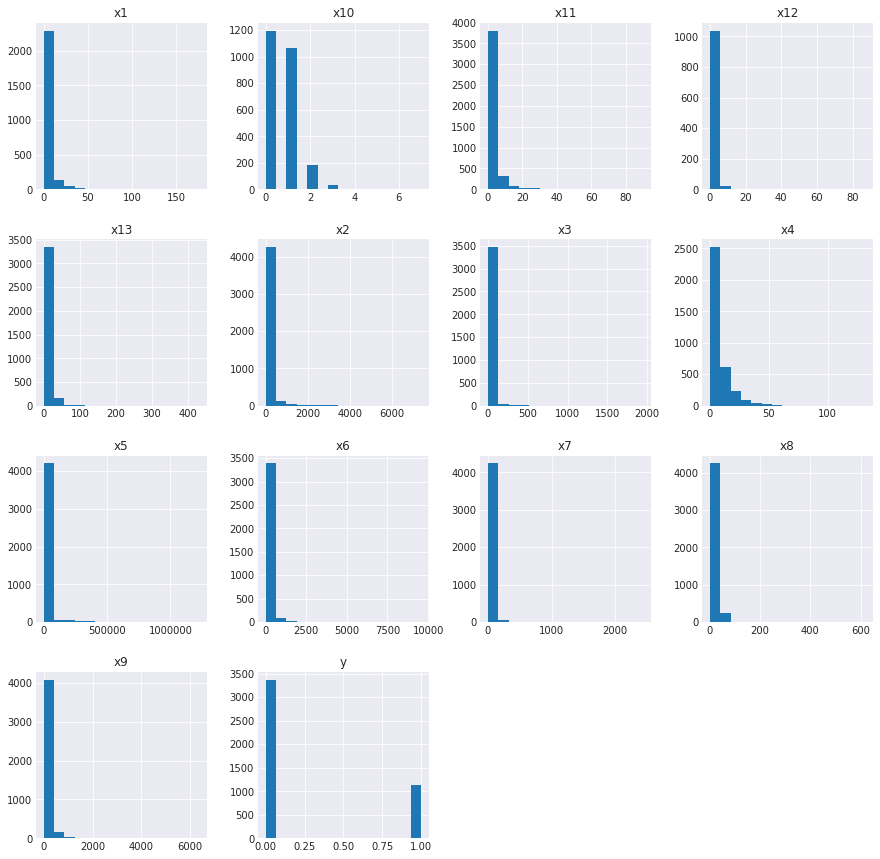

In [25]:
sample[INTEGER_FEATURES].hist(figsize=(15,15), bins=15)

/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_base.py:3152: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=1.0, right=1.0
  'left=%s, right=%s') % (left, right))


Text(0.5,0.9,'Individual Features vs. Click Through')

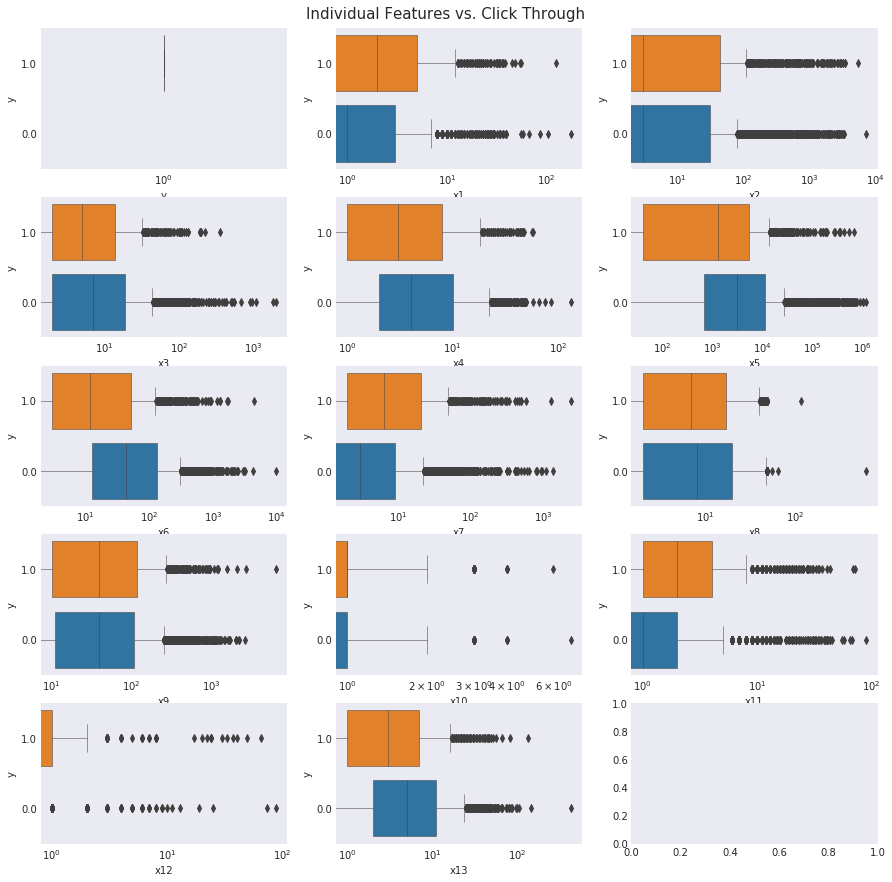

In [14]:
fig, ax_grid = plt.subplots(5, 3, figsize=(15,15))
y = sample['y']
for idx, feature in enumerate(INTEGER_FEATURES):
    x = sample[feature]
    box = sns.boxplot(x, y, ax=ax_grid[idx//3][idx%3], orient='h', linewidth=.5)
    ax_grid[idx//3][idx%3].invert_yaxis()
    box.set(xscale="log")
fig.suptitle("Individual Features vs. Click Through", fontsize=15, y=0.9)
#plt.show()

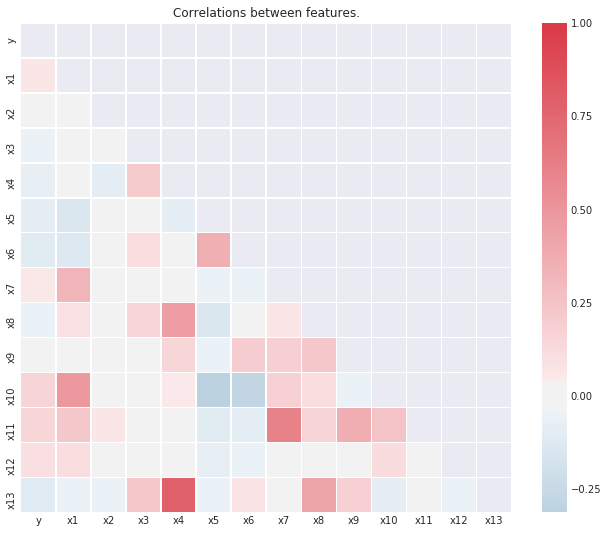

In [23]:
# plot heatmap for correlations matrix - RUN THIS CELL AS IS
corr = sample[INTEGER_FEATURES].corr()
fig, ax = plt.subplots(figsize=(11, 9))
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(240, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, linewidths=.5)
plt.title("Correlations between features.")
plt.show()

In [26]:
for feature in CATEGORICAL_FEATURES:
    unique = set(sample[sample["y"]==1][feature].unique())-set(sample[sample["y"]==0][feature].unique())
    print("{} has {} unique features between y=0 and y=1 examples".format(feature, len(unique)))

x14 has 16 unique features between y=0 and y=1 examples
x15 has 27 unique features between y=0 and y=1 examples
x16 has 711 unique features between y=0 and y=1 examples
x17 has 505 unique features between y=0 and y=1 examples
x18 has 2 unique features between y=0 and y=1 examples
x19 has 1 unique features between y=0 and y=1 examples
x20 has 317 unique features between y=0 and y=1 examples
x21 has 7 unique features between y=0 and y=1 examples
x22 has 0 unique features between y=0 and y=1 examples
x23 has 357 unique features between y=0 and y=1 examples
x24 has 186 unique features between y=0 and y=1 examples
x25 has 678 unique features between y=0 and y=1 examples
x26 has 154 unique features between y=0 and y=1 examples
x27 has 2 unique features between y=0 and y=1 examples
x28 has 248 unique features between y=0 and y=1 examples
x29 has 613 unique features between y=0 and y=1 examples
x30 has 0 unique features between y=0 and y=1 examples
x31 has 141 unique features between y=0 and y

# We Will Need to Impute Values rather than Filling with 0's

In [18]:
def imputeValues(df, dftest):
    # Impute numerical features
    for col in INTEGER_FEATURES[1:]:
        mean = df.select(col).agg({col:'mean'}).collect()[0][0]
        print(f"Column {col} has mean {mean}")
        df = df.withColumn(col, F.when(df[col].isNull(), mean).otherwise(df[col]))
        dftest = dftest.withColumn(col, F.when(dftest[col].isNull(), mean).otherwise(dftest[col]))
    print("Successfully Imputed Numerical Values")

    # Impute categorical features
    for col in CATEGORICAL_FEATURES:
        mostCommon = df.select(col).groupby(col).count()\
                            .orderBy('count', ascending=False) \
                            .limit(1).collect()[0][0]
        if mostCommon == "":
            mostCommon = "EMPTY"
        
        print(f"Column {col} has most common {mostCommon}")
        
        df = df.withColumn(col, F.when((df[col].isNull() | 
                                       (df[col] == '')), mostCommon) \
                                .otherwise(df[col]))
        dftest = dftest.withColumn(col, F.when((dftest[col].isNull() | 
                               (dftest[col] == '')), mostCommon) \
                        .otherwise(dftest[col]))
    print("Successfully Imputed Categorical Values")
    
    # Assure there is no missing values
    for col in INTEGER_FEATURES[1:] + CATEGORICAL_FEATURES:
        assert df.filter(df[col].isNull()).count() == 0, f"Column {col} contains NULL value(s)"
        assert df.filter(df[col] == '').count() == 0, f"Column {col} contains empty string(s)"
    
        assert dftest.filter(dftest[col].isNull()).count() == 0, f"Column {col} contains NULL value(s)"
        assert dftest.filter(dftest[col] == '').count() == 0, f"Column {col} contains empty string(s)"
    
    print("Successfully Imputed All Values and Passed Tests")
    return (df, dftest)

In [19]:
start = time.time()
trainDF, testDF = imputeValues(trainDF, testDF)
print(f"\n... Executed in {time.time() - start} seconds")

Column x1 has mean 3.5024133170754044
Column x2 has mean 105.84841979766546
Column x3 has mean 26.913041020611274
Column x4 has mean 7.322680248873305
Column x5 has mean 18538.991664871523
Column x6 has mean 116.06185085211598
Column x7 has mean 16.333130032135028
Column x8 has mean 12.517042137556713
Column x9 has mean 106.1098234380509
Column x10 has mean 0.6175294977722137
Column x11 has mean 2.7328343170173044
Column x12 has mean 0.9910356287721244
Column x13 has mean 8.217461161174054
Successfully Imputed Numerical Values
Column x14 has most common 05db9164
Column x15 has most common 38a947a1
Column x16 has most common EMPTY
Column x17 has most common c18be181
Column x18 has most common 25c83c98
Column x19 has most common 7e0ccccf
Column x20 has most common 1c86e0eb
Column x21 has most common 0b153874
Column x22 has most common a73ee510
Column x23 has most common 3b08e48b
Column x24 has most common 755e4a50
Column x25 has most common EMPTY
Column x26 has most common 5978055e
Colum

In [20]:
trainDF.take(1)

[Row(y=0.0, x1=1.0, x2=-1.0, x3=5.0, x4=3.0, x5=5.0, x6=3.0, x7=1.0, x8=3.0, x9=3.0, x10=1.0, x11=1.0, x12=0.9910356287721244, x13=3.0, x14='8cf07265', x15='65265295', x16='bf61fc9a', x17='db9c39b1', x18='4cf72387', x19='7e0ccccf', x20='48db53e5', x21='0b153874', x22='a73ee510', x23='041560b6', x24='fe1bd1df', x25='bc6454e7', x26='3787a7a6', x27='07d13a8f', x28='b30b312f', x29='cbec8e09', x30='d4bb7bd8', x31='abad9dca', x32='21ddcdc9', x33='b1252a9d', x34='42d9424d', x35='EMPTY', x36='423fab69', x37='e7540df6', x38='9b3e8820', x39='5103b5f2')]

# We Will Need to Apply Standard Scaler to the Features

# We will need to one hot encode the categorical variables

This article has some detail on doing this.

https://towardsdatascience.com/feature-encoding-with-spark-2-3-0-part-1-9ede45562740  
https://chih-ling-hsu.github.io/2018/09/17/spark-mllib  

# We Will Need to Combine The Above into a Pipeline

In [21]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, StandardScaler, Imputer, VectorAssembler, SQLTransformer
from pyspark.ml import Pipeline, PipelineModel

In [22]:
# Based on Code from: https://chih-ling-hsu.github.io/2018/09/17/spark-mllib

def preprocessData(df):
    # String Indexing for categorical features
    indexers = [StringIndexer(inputCol=col, 
                              outputCol="{}_idx".format(col)) \
                              for col in CATEGORICAL_FEATURES]
    
    # One-hot encoding for categorical features
    encoders = [OneHotEncoder(inputCol="{}_idx".format(col), 
                              outputCol="{}_oh".format(col)) \
                              for col in CATEGORICAL_FEATURES]

    # Concat Feature Columns
    assembler = VectorAssembler(inputCols = INTEGER_FEATURES[1:] + \
                            ["{}_oh".format(col) for col in CATEGORICAL_FEATURES], 
                            outputCol = "_features")
    
    # Standardize Features
    scaler = StandardScaler(inputCol='_features', 
                            outputCol='features', 
                            withStd=True, withMean=False)

    preprocessor = Pipeline(stages = indexers + encoders + \
                                     [assembler, scaler]).fit(df)

    return preprocessor

In [ ]:
start = time.time()
# Pre-Process All Training Data
preprocessor = preprocessData(trainDF.repartition(400))   
print(f"\n... Executed in {time.time() - start} seconds")

In [19]:
# # Based on Code from: https://chih-ling-hsu.github.io/2018/09/17/spark-mllib

# def gen_preprocessor(df):
#     # String Indexing for categorical features
#     indexers = [StringIndexer(inputCol=col, 
#                               outputCol="{}_idx".format(col)) \
#                               for col in CATEGORICAL_FEATURES]
    
#     # One-hot encoding for categorical features
#     encoders = [OneHotEncoder(inputCol="{}_idx".format(col), 
#                               outputCol="{}_oh".format(col)) \
#                               for col in CATEGORICAL_FEATURES]

#     # Concat Feature Columns
#     assembler = VectorAssembler(inputCols = INTEGER_FEATURES[1:] + \
#                             ["{}_oh".format(col) for col in CATEGORICAL_FEATURES], 
#                             outputCol = "_features")
    
#     # Standardize Features
#     scaler = StandardScaler(inputCol='_features', 
#                             outputCol='features', 
#                             withStd=True, withMean=False)

#     preprocessor = Pipeline(stages = indexers + encoders + [assembler]).fit(df)

#     return preprocessor

We will pre-process the data but the file is very large and we run into OOM errors when trying to fit on the entire data set.  We can fit the pre-processor on a sample of 5% of the data and then transform the rest of the dataframes

In [18]:
#Let's Run pre-processor on a sample of the data
# sampleDF = trainDF.sample(False, 0.5, seed=1234)

In [20]:
start = time.time()
# Pre-Process All Training Data
preprocessor = gen_preprocessor(trainDF)   
print(f"\n... Executed in {time.time() - start} seconds")


... Executed in 236.3617284297943 seconds


In [21]:
start = time.time()
preprocessor.save("preprocessor_OHE")
print(f"\n... Executed in {time.time() - start} seconds")


... Executed in 29.71653938293457 seconds


# Load our Pipeline Model

In [17]:
start = time.time()
preprocessor = PipelineModel.load('preprocessor_OHE')
print(f"\n... Executed in {time.time() - start} seconds")


... Executed in 40.241495847702026 seconds


In [18]:
start = time.time()
trainDF = preprocessor.transform(trainDF).cache()
print(f"\n... Executed in {time.time() - start} seconds")


... Executed in 413.15598344802856 seconds


In [21]:
# Save to Parquet so We do Not Need to Pre-process again
start = time.time()
trainDF.select(['y','_features']).write.parquet("preprocessed_train.parquet")
print(f"\n... Executed in {time.time() - start} seconds")

Py4JJavaError: An error occurred while calling o1178.parquet.
: java.lang.OutOfMemoryError: Java heap space


In [22]:
2+2

4

In [25]:
start = time.time()
# Pre-Process All Test Data
testDF = preprocessor.transform(testDF) 
print(f"\n... Executed in {time.time() - start} seconds")


... Executed in 277.6817252635956 seconds


In [27]:
# Save to Parquet so We do Not Need to Pre-process again
start = time.time()
testDF.write.parquet("preprocessed_test.parquet")
print(f"\n... Executed in {time.time() - start} seconds")

Py4JJavaError: An error occurred while calling o3347.parquet.
: java.lang.OutOfMemoryError: GC overhead limit exceeded
	at scala.collection.mutable.ListBuffer.$plus$eq(ListBuffer.scala:174)
	at scala.collection.mutable.ListBuffer.$plus$eq(ListBuffer.scala:45)
	at scala.collection.generic.Growable$$anonfun$$plus$plus$eq$1.apply(Growable.scala:59)
	at scala.collection.generic.Growable$$anonfun$$plus$plus$eq$1.apply(Growable.scala:59)
	at scala.collection.immutable.Map$Map2.foreach(Map.scala:137)
	at scala.collection.generic.Growable$class.$plus$plus$eq(Growable.scala:59)
	at scala.collection.mutable.ListBuffer.$plus$plus$eq(ListBuffer.scala:183)
	at scala.collection.mutable.ListBuffer.$plus$plus$eq(ListBuffer.scala:45)
	at scala.collection.TraversableLike$class.to(TraversableLike.scala:590)
	at scala.collection.AbstractTraversable.to(Traversable.scala:104)
	at scala.collection.TraversableOnce$class.toList(TraversableOnce.scala:294)
	at scala.collection.AbstractTraversable.toList(Traversable.scala:104)
	at org.apache.spark.sql.types.Metadata$.org$apache$spark$sql$types$Metadata$$toJsonValue(Metadata.scala:180)
	at org.apache.spark.sql.types.Metadata$$anonfun$2.apply(Metadata.scala:183)
	at org.apache.spark.sql.types.Metadata$$anonfun$2.apply(Metadata.scala:183)
	at scala.collection.immutable.List.map(List.scala:277)
	at org.apache.spark.sql.types.Metadata$.org$apache$spark$sql$types$Metadata$$toJsonValue(Metadata.scala:183)
	at org.apache.spark.sql.types.Metadata$$anonfun$1.apply(Metadata.scala:180)
	at org.apache.spark.sql.types.Metadata$$anonfun$1.apply(Metadata.scala:180)
	at scala.collection.immutable.List.map(List.scala:273)
	at org.apache.spark.sql.types.Metadata$.org$apache$spark$sql$types$Metadata$$toJsonValue(Metadata.scala:180)
	at org.apache.spark.sql.types.Metadata$$anonfun$1.apply(Metadata.scala:180)
	at org.apache.spark.sql.types.Metadata$$anonfun$1.apply(Metadata.scala:180)
	at scala.collection.immutable.List.map(List.scala:273)
	at org.apache.spark.sql.types.Metadata$.org$apache$spark$sql$types$Metadata$$toJsonValue(Metadata.scala:180)
	at org.apache.spark.sql.types.Metadata$$anonfun$1.apply(Metadata.scala:180)
	at org.apache.spark.sql.types.Metadata$$anonfun$1.apply(Metadata.scala:180)
	at scala.collection.immutable.List.map(List.scala:273)
	at org.apache.spark.sql.types.Metadata$.org$apache$spark$sql$types$Metadata$$toJsonValue(Metadata.scala:180)
	at org.apache.spark.sql.types.Metadata.jsonValue(Metadata.scala:114)
	at org.apache.spark.sql.types.StructField.jsonValue(StructField.scala:57)
	at org.apache.spark.sql.types.StructType$$anonfun$jsonValue$2.apply(StructType.scala:327)


In [ ]:
trainDF.take(1)

In [26]:
# Save to Parquet so We do Not Need to Pre-process again
start = time.time()
trainDF.write.parquet("preprocessed_train.parquet")
print(f"\n... Executed in {time.time() - start} seconds")

Py4JJavaError: An error occurred while calling o3312.parquet.
: java.lang.OutOfMemoryError: GC overhead limit exceeded
	at java.math.BigInteger.valueOf(BigInteger.java:1107)
	at scala.math.BigInt$.apply(BigInt.scala:49)
	at scala.math.BigInt$.long2bigInt(BigInt.scala:101)
	at org.apache.spark.sql.types.Metadata$.org$apache$spark$sql$types$Metadata$$toJsonValue(Metadata.scala:186)
	at org.apache.spark.sql.types.Metadata$$anonfun$1.apply(Metadata.scala:180)
	at org.apache.spark.sql.types.Metadata$$anonfun$1.apply(Metadata.scala:180)
	at scala.collection.immutable.List.map(List.scala:273)
	at org.apache.spark.sql.types.Metadata$.org$apache$spark$sql$types$Metadata$$toJsonValue(Metadata.scala:180)
	at org.apache.spark.sql.types.Metadata$$anonfun$2.apply(Metadata.scala:183)
	at org.apache.spark.sql.types.Metadata$$anonfun$2.apply(Metadata.scala:183)
	at scala.collection.immutable.List.map(List.scala:277)
	at org.apache.spark.sql.types.Metadata$.org$apache$spark$sql$types$Metadata$$toJsonValue(Metadata.scala:183)
	at org.apache.spark.sql.types.Metadata$$anonfun$1.apply(Metadata.scala:180)
	at org.apache.spark.sql.types.Metadata$$anonfun$1.apply(Metadata.scala:180)
	at scala.collection.immutable.List.map(List.scala:273)
	at org.apache.spark.sql.types.Metadata$.org$apache$spark$sql$types$Metadata$$toJsonValue(Metadata.scala:180)
	at org.apache.spark.sql.types.Metadata$$anonfun$1.apply(Metadata.scala:180)
	at org.apache.spark.sql.types.Metadata$$anonfun$1.apply(Metadata.scala:180)
	at scala.collection.immutable.List.map(List.scala:273)
	at org.apache.spark.sql.types.Metadata$.org$apache$spark$sql$types$Metadata$$toJsonValue(Metadata.scala:180)
	at org.apache.spark.sql.types.Metadata$$anonfun$1.apply(Metadata.scala:180)
	at org.apache.spark.sql.types.Metadata$$anonfun$1.apply(Metadata.scala:180)
	at scala.collection.immutable.List.map(List.scala:273)
	at org.apache.spark.sql.types.Metadata$.org$apache$spark$sql$types$Metadata$$toJsonValue(Metadata.scala:180)
	at org.apache.spark.sql.types.Metadata.jsonValue(Metadata.scala:114)
	at org.apache.spark.sql.types.StructField.jsonValue(StructField.scala:57)
	at org.apache.spark.sql.types.StructType$$anonfun$jsonValue$2.apply(StructType.scala:327)
	at org.apache.spark.sql.types.StructType$$anonfun$jsonValue$2.apply(StructType.scala:327)
	at scala.collection.TraversableLike$$anonfun$map$1.apply(TraversableLike.scala:234)
	at scala.collection.TraversableLike$$anonfun$map$1.apply(TraversableLike.scala:234)
	at scala.collection.Iterator$class.foreach(Iterator.scala:893)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1336)


# Train and Validation Data Sets

In [ ]:
# Load From Parquet
trainDF = sqlContext.read.parquet('preprocessed_train.parquet')
testDF = sqlContext.read.parquet('preprocessed_test.parquet')

In [23]:
# Generate 80/20 (pseudo)random train/test split 
start = time.time()
trainingDF, validDF = trainDF.randomSplit([0.8,0.2], seed = 1)
print(f"... held out {validDF.count()} records for evaluation and assigned {trainingDF.count()} for training.")
print(f"\n... Executed in {time.time() - start} seconds")

... held out 9172331 records for evaluation and assigned 36668286 for training.

... Executed in 73.14105606079102 seconds


# Example of playing around with the RDD pipeline

In [20]:
validDF.take(1)

[Row(y=0, x1=None, x2=-2, x3=None, x4=None, x5=10091, x6=None, x7=0, x8=10, x9=37, x10=None, x11=0, x12=None, x13=None, x14='05db9164', x15='04e09220', x16='99b1c7f1', x17='a1e6a194', x18='43b19349', x19='7e0ccccf', x20='5f3a87ef', x21='1f89b562', x22='a73ee510', x23='74273dde', x24='69efa7ec', x25='dd727b99', x26='99b4a17d', x27='f862f261', x28='33b0f0e1', x29='23056e4f', x30='1e88c74f', x31='e161d23a', x32='', x33='', x34='cf6b91c6', x35='', x36='32c7478e', x37='ded4aac9', x38='', x39='')]

In [21]:
integerTrainingDF = trainingDF[INTEGER_FEATURES]
integerValidDF = validDF[INTEGER_FEATURES]

In [22]:
# integerTrainingDF = integerTrainingDF.dropna()
integerTrainingDF = integerTrainingDF.fillna(0)
integerValidDF = integerValidDF.fillna(0)

In [23]:
integerTrainingDF.take(1)

[Row(y=0, x1=0, x2=-2, x3=0, x4=0, x5=2890, x6=0, x7=0, x8=9, x9=16, x10=0, x11=0, x12=0, x13=0)]

In [24]:
assembler = VectorAssembler(inputCols = INTEGER_FEATURES[1:], outputCol = 'features')
integerVectorTrainDF = assembler.transform(integerTrainingDF)
integerVectorTrainDF = integerVectorTrainDF.select(['features', 'y'])

integerValidDF = assembler.transform(integerValidDF)
integerValidDF = integerValidDF.select(['features', 'y'])

In [25]:
integerVectorTrainDF.take(3)

[Row(features=SparseVector(13, {1: -2.0, 4: 2890.0, 7: 9.0, 8: 16.0}), y=0),
 Row(features=SparseVector(13, {1: -2.0, 4: 4383.0, 7: 18.0, 8: 29.0}), y=0),
 Row(features=SparseVector(13, {1: -2.0, 4: 6387.0, 5: 15.0, 6: 4.0, 7: 14.0, 8: 15.0, 10: 1.0}), y=0)]

### Linear Regression Model

In [58]:
from pyspark.ml.regression import LinearRegression

start = time.time()
lr = LinearRegression(featuresCol = 'features', labelCol='y', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(integerVectorTrainDF)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))
print(f"\n... Executed in {time.time() - start} seconds")

Coefficients: [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
Intercept: 0.2562331929013535

... Executed in 472.1147437095642 seconds


In [59]:
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 0.436552
r2: 0.000000


In [61]:
predictions = lr_model.transform(integerValidDF)
predictions.select("prediction","y","features").show()

+------------------+---+--------------------+
|        prediction|  y|            features|
+------------------+---+--------------------+
|0.2562331929013535|  0|(13,[1,4,7,8],[-2...|
|0.2562331929013535|  0|(13,[1,4,5,6,7,8,...|
|0.2562331929013535|  0|(13,[1,4],[-2.0,1...|
|0.2562331929013535|  0|(13,[1,3,4,7,8,12...|
|0.2562331929013535|  0|(13,[1,2,4,8],[-2...|
|0.2562331929013535|  0|[0.0,-2.0,1.0,0.0...|
|0.2562331929013535|  0|[0.0,-2.0,1.0,0.0...|
|0.2562331929013535|  0|[0.0,-2.0,1.0,0.0...|
|0.2562331929013535|  0|[0.0,-2.0,1.0,0.0...|
|0.2562331929013535|  0|(13,[1,2,4,8],[-2...|
|0.2562331929013535|  0|(13,[1,2,4,7,8],[...|
|0.2562331929013535|  0|(13,[1,2,3,4,7,8,...|
|0.2562331929013535|  0|(13,[1,2,3,4,7,8,...|
|0.2562331929013535|  0|(13,[1,2,4,7],[-2...|
|0.2562331929013535|  0|(13,[1,2,3,4,7,8,...|
|0.2562331929013535|  0|[0.0,-2.0,3.0,3.0...|
|0.2562331929013535|  0|[0.0,-2.0,3.0,6.0...|
|0.2562331929013535|  0|(13,[1,2],[-2.0,4...|
|0.2562331929013535|  0|[0.0,-2.0,

### Decision Tree Model

In [64]:
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator

start = time.time()
dt = DecisionTreeRegressor(featuresCol ='features', labelCol = 'y')
dt_model = dt.fit(integerVectorTrainDF)
dt_predictions = dt_model.transform(integerValidDF)
dt_evaluator = RegressionEvaluator(
    labelCol="y", predictionCol="prediction", metricName="rmse")
rmse = dt_evaluator.evaluate(dt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)
print(f"\n... Executed in {time.time() - start} seconds")

Root Mean Squared Error (RMSE) on test data = 0.414117

... Executed in 620.8756322860718 seconds


In [65]:
dt_model.featureImportances

SparseVector(13, {0: 0.3625, 2: 0.0251, 3: 0.0064, 4: 0.0175, 5: 0.2658, 6: 0.0339, 7: 0.0319, 10: 0.2173, 12: 0.0396})

### Gradient Boosted Tree Model

In [26]:
from pyspark.ml.regression import GBTRegressor

start = time.time()
gbt = GBTRegressor(featuresCol = 'features', labelCol = 'y', maxIter=10)
gbt_model = gbt.fit(integerVectorTrainDF)
gbt_predictions = gbt_model.transform(integerValidDF)
gbt_predictions.select('prediction', 'y', 'features').show(5)
print(f"\n... Executed in {time.time() - start} seconds")

+-------------------+---+--------------------+
|         prediction|  y|            features|
+-------------------+---+--------------------+
| 0.1517156633342715|  0|(13,[1,4,7,8],[-2...|
|0.44056266316284565|  0|(13,[1,4,5,6,7,8,...|
| 0.2128448358271377|  0|(13,[1,4],[-2.0,1...|
|0.14118529246433426|  0|(13,[1,3,4,7,8,12...|
|0.18318805474933217|  0|(13,[1,2,4,8],[-2...|
+-------------------+---+--------------------+
only showing top 5 rows


... Executed in 1696.0577931404114 seconds


In [29]:
from pyspark.ml.evaluation import RegressionEvaluator

start = time.time()
gbt_evaluator = RegressionEvaluator(
    labelCol="y", predictionCol="prediction", metricName="rmse")
rmse = gbt_evaluator.evaluate(gbt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)
print(f"\n... Executed in {time.time() - start} seconds")

Root Mean Squared Error (RMSE) on test data = 0.411841

... Executed in 50.218480587005615 seconds


### Logistic Regression Model

In [30]:
from pyspark.ml.classification import LogisticRegression

start = time.time()
lr = LogisticRegression(featuresCol = 'features', labelCol='y', maxIter=10, regParam=0.01)
lr_model = lr.fit(integerVectorTrainDF)

lr_predictions = gbt_model.transform(integerValidDF)
lr_predictions.select('prediction', 'y', 'features').show(5)

print("LogisticRegression parameters:\n" + lr.explainParams() + "\n")
print(f"\n... Executed in {time.time() - start} seconds")

+-------------------+---+--------------------+
|         prediction|  y|            features|
+-------------------+---+--------------------+
| 0.1517156633342715|  0|(13,[1,4,7,8],[-2...|
|0.44056266316284565|  0|(13,[1,4,5,6,7,8,...|
| 0.2128448358271377|  0|(13,[1,4],[-2.0,1...|
|0.14118529246433426|  0|(13,[1,3,4,7,8,12...|
|0.18318805474933217|  0|(13,[1,2,4,8],[-2...|
+-------------------+---+--------------------+
only showing top 5 rows

LogisticRegression parameters:
aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)
elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0)
family: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)
featuresCol: features column name. (default: features, current: features)
fitIntercept: whether to fit an intercept term.

In [31]:
from pyspark.ml.evaluation import RegressionEvaluator

start = time.time()
lr_evaluator = RegressionEvaluator(
    labelCol="y", predictionCol="prediction", metricName="rmse")
rmse = lr_evaluator.evaluate(lr_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)
print(f"\n... Executed in {time.time() - start} seconds")

Root Mean Squared Error (RMSE) on test data = 0.411841

... Executed in 47.0909161567688 seconds


# We Should Combine The Above into an Ensemble Model

# Comparison between CSV & Parquet

Apache parquet file format is designed to more efficiently store columnar data rather than by row such as using a file format like csv.  Parquet is optimized to minimize file I/O and efficiently compresses.  Parquet can be queried more efficiently with SQL than csv files.  When using a cloud platform, users may be charged by I/O so use of a csv will be more expensive when compared to parquet.  Additionally, because parquet is faster, computation charges are correspondingly lower as well.  Parquet file format may yield a performance improvement around 10x, or an order of magnitude, when compared to performance on a csv.

Additionally, parquet file format allows for easy use of a spark DF as it has performance improvements relative to RDD.  

https://dzone.com/articles/how-to-be-a-hero-with-powerful-parquet-google-and  
https://developer.ibm.com/hadoop/2016/01/14/5-reasons-to-choose-parquet-for-spark-sql/  
https://mapr.com/blog/tips-and-best-practices-to-take-advantage-of-spark-2-x/  

# ML Lib Use  

In this project we will leverage the MLlib RDD based API to perform machine learning algorithms on our dataset

https://spark.apache.org/docs/latest/mllib-guide.html  

## Table of Contents

* __Section 1__ - Question Formulation
* __Section 2__ - Algorithm Explanation
* __Section 3__ - EDA & Challenges
* __Section 4__ - Algorithm Implementation
* __Section 5__ - Course Concepts

# __Section 1__ - Question Formulation

# __Section 2__ - Algorithm Explanation

# __Section 3__ - EDA & Challenges

# __Section 4__ - Algorithm Implementation

# __Section 5__ - Course Concepts